# **Phân tích, trực quan hoá, đưa ra insight**
- Ở bước này chúng ta sẽ cùng nhau tìm hiểu *câu chuyện* phía sau dữ liệu của chúng ta có những gì, đồng thời cũng rút ra những insight quan trọng từ dữ liệu.
- Chúng ta sẽ thực hiện phân tích dữ liệu qua các bước sau:
    - Thống kê mô tả dữ liệu: tập trung vào các đặc trưng (fatalities, injuries, landslide_category, landslide_trigger, ...) để hiểu rõ hơn về phân phối và các đặc điểm chính của chúng.
    - Phân tích địa lý: sử dụng các biểu đồ bản đồ để trực quan hóa phân bố địa lý của các sự kiện lở đất, từ đó nhận diện các khu vực có nguy cơ cao.
    - Phân tích theo thời gian: khám phá xu hướng theo thời gian của các sự kiện lở đất, bao gồm sự thay đổi theo năm, mùa và các yếu tố thời tiết
    - Phân tích mối quan hệ giữa các biến: sử dụng các biểu đồ tương quan để tìm hiểu mối quan hệ giữa các biến khác nhau trong dữ liệu.
    - Cuối cùng, chúng ta sẽ tổng hợp các phát hiện quan trọng và đưa ra các kết luận từ phân tích dữ liệu.
- Trong các bước trên, chúng ta cũng tích hợp trả lời các câu hỏi có ý nghĩa.


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

import sys
import os
sys.path.append(os.path.abspath(r"..\src"))

import config as cf
import data_processing as dp 
import utils as ut 

In [38]:
df = pd.read_csv(cf.RAW_DATA)
print(f"Dữ liệu có kích thước: {df.shape}")
df.head(3)

Dữ liệu có kích thước: (11033, 31)


source_name                                        source_link  event_id  \
0         AGU  https://blogs.agu.org/landslideblog/2008/10/14...       684   
1   Oregonian  http://www.oregonlive.com/news/index.ssf/2009/...       956   
2    CBS News  https://www.cbsnews.com/news/dozens-missing-af...       973   

               event_date  event_time  \
0  08/01/2008 12:00:00 AM         NaN   
1  01/02/2009 02:00:00 AM         NaN   
2  01/19/2007 12:00:00 AM         NaN   

                                         event_title  \
0      Sigou Village, Loufan County, Shanxi Province   
1                                Lake Oswego, Oregon   
2  San Ramon district, 195 miles northeast of the...   

                                   event_description  \
0  occurred early in morning, 11 villagers buried...   
1  Hours of heavy rain are to blame for an overni...   
2  (CBS/AP) At least 10 people died and as many a...   

                                location_description location_accuracy  \
0      Sigou Village, Loufan County, Shanxi Province           unknown   
1                                Lake Oswego, Oregon               5km   
2  San Ramon district, 195 miles northeast of the...              10km   

  landslide_category  ... country_code admin_division_name  \
0          landslide  ...           CN             Shaanxi   
1           mudslide  ...           US              Oregon   
2          landslide  ...           PE               Junín   

  admin_division_population  gazeteer_closest_point  gazeteer_distance  \
0                       0.0                Jingyang           41.02145   
1                   36619.0             Lake Oswego            0.60342   
2                   14708.0               San Ramón            0.85548   

           submitted_date            created_date        last_edited_date  \
0  04/01/2014 12:00:00 AM  11/20/2017 03:17:00 PM  02/15/2018 03:51:00 PM   
1  04/01/2014 12:00:00 AM  11/20/2017 03:17:00 PM  02/15/2018 03:51:00 PM   
2  04/01/2014 12:00:00 AM  11/20/2017 03:17:00 PM  02/15/2018 03:51:00 PM   

  longitude  latitude  
0  107.4500   32.5625  
1 -122.6630   45.4200  
2  -75.3587  -11.1295  

[3 rows x 31 columns]

## **Những thứ râu ria**

In [39]:
cols_to_drop = [
    #'event_id',
    'event_import_id', 
    'event_import_source', 
    'created_date', 
    'submitted_date', 
    'last_edited_date',
    'source_link', 
    'photo_link', 
    'storm_name',
    'country_code', 
    'event_time', 
    'notes',
    'gazeteer_closest_point', 
    'gazeteer_distance'
]

# Xóa cột 
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

print(f"Kích thước sau khi xóa cột thừa: {df.shape}")


Kích thước sau khi xóa cột thừa: (11033, 18)


In [40]:
# Chuyển đổi sang datetime, các giá trị lỗi sẽ biến thành NaT
df['event_date'] = pd.to_datetime(df['event_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

print("Đã hoàn thành xử lý thời gian.")

Đã hoàn thành xử lý thời gian.


In [41]:
cols_to_fix = ['event_description', 'location_description', 
               'admin_division_name', 'event_title','source_name', 'admin_division_name', 'country_name']
for col in cols_to_fix:
    df[col] = df[col].apply(ut.fix_encoding)

print("Đã sửa xong lỗi font cho các cột văn bản.")

Đã sửa xong lỗi font cho các cột văn bản.


In [42]:
df = df.apply(dp.fill_missing_locations, axis=1)
print("Hoàn tất")

Hoàn tất


In [43]:
def clean_text(text):
    # Nếu là giá trị rỗng (NaN) thì trả về 'unknown'
    if pd.isna(text):
        return "unknown"
    
    # Chuyển về chữ thường và xoá khoảng trắng thừa ở 2 đầu
    return str(text).lower().strip()

# --- ÁP DỤNG ---
# Danh sách các cột bạn muốn xử lý
text_columns = ['landslide_category', 'landslide_trigger', 'landslide_size', 'country_name', 'admin_division_name']

for col in text_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)

# Kiểm tra nhanh kết quả
df[text_columns].head(100)

landslide_category landslide_trigger landslide_size   country_name  \
0           landslide              rain          large          china   
1            mudslide          downpour          small  united states   
2           landslide          downpour          large           peru   
3           landslide           monsoon         medium          nepal   
4           landslide  tropical_cyclone         medium    philippines   
..                ...               ...            ...            ...   
95          landslide          downpour         medium    philippines   
96          landslide              rain          large          india   
97          landslide          downpour          large  united states   
98          landslide          downpour         medium          india   
99          landslide          downpour          large          india   

   admin_division_name  
0              shaanxi  
1               oregon  
2                junín  
3          mid western  
4      central visayas  
..                 ...  
95     central visayas  
96              sikkim  
97              oregon  
98    himachal pradesh  
99              sikkim  

[100 rows x 5 columns]

## **Question Formation**
### **Câu hỏi 1. Sạt lở có phải là một hiểm họa có tính quy luật không? Quy luật phân bố theo không gian và thời gian của nó như thế nào?**

**Phương pháp chính**
- Phân tích xu hướng sạt lở theo các năm, các tháng. 
- Để có thể phân tích các vụ sạt lở có theo tính quy luật nào hay không, nhóm em đã đưa ra hai phương án để phân vùng:
    - Chia theo vùng khí hậu [Nhiệt đới (tropical), Cận nhiệt đới (subtropical), Ôn đới (temperate), Cận hàn đới (subpolar) và Hàn đới (polar)]: chia theo vĩ độ (abs vĩ độ)
        + Nhiệt đới: 0 - 23.5
        + Cận nhiệt đới: 23.5 - 35
        + Ôn đới:  35 - 60
        + Cận hàn đới:  60 - 66.5      
        + Hàn đới: 66.5
    - Chia theo khu vực trên thế giới, chia theo kinh độ và vĩ độ:
        + Kinh độ < -30: Thuộc châu Mỹ, nếu vĩ độ > 8 là Bắc Mỹ, không thì Nam Mỹ
        + Kinh độ từ -30 đến 60: Là châu Âu và Phi, nếu vĩ độ > 30 là châu Âu, không là châu phi
        + Kinh độ >= 60: Châu Á hoặc Úc, nếu kinh độ < 95 là Nam Á, ngược lại thêm vĩ độ > 25 thì là Đông Á, Không là thuộc Đông Nam Á + Úc
- Dựa trên 2 phương án phân vùng đó để phác hoạ xem ở vùng khí hậu nào xảy ra hiện tượng sạt lở nhất

**Kết quả mong đợi**
- Rút ra được sạt lở mang tính quy luật
- Chỉ ra được xu hướng

In [44]:
df['event_date'] = pd.to_datetime(
    df['event_date'],
    errors='coerce'
)
df['year'] = df['event_date'].dt.year
df['month'] = df['event_date'].dt.month

#### **1.1 Sạt lở có xảy ra đều theo thời gian hay tập trung vào 1 thời gian nhất định?**

**Phương pháp**
- Chủ yếu chỉ ra được xu hướng của các vụ sạt lở theo thời gian và đưa ra nhận xét về xu hướng
- Như đã đề cập ở bước *Khám phá dữ liệu*, từ giờ nhóm sẽ sử dụng dữ liệu tập trung từ năm 2007 - 2017 (các năm về trước thời gian này số vụ không đáng kể)



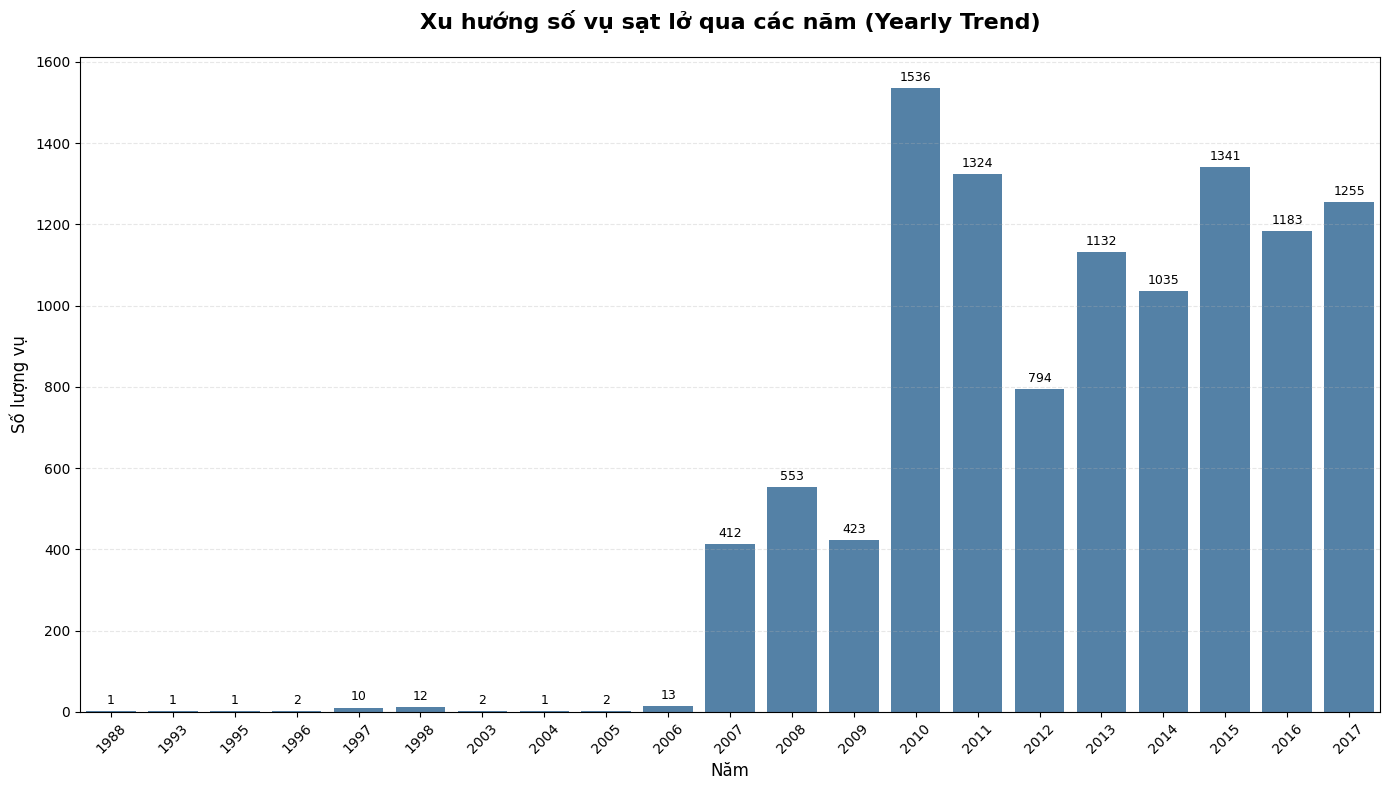

In [45]:
plt.figure(figsize=(14, 8))

# Biểu đồ 1: Xu hướng theo Năm (Yearly Trend)
sns.countplot(data=df, x='year', color='steelblue')
plt.title('Xu hướng số vụ sạt lở qua các năm (Yearly Trend)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Số lượng vụ', fontsize=12)
plt.xlabel('Năm', fontsize=12)
plt.xticks(rotation=45)  # Xoay nhãn năm cho dễ đọc
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Thêm giá trị trên mỗi cột (tùy chọn)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.0f', fontsize=9, padding=3)

plt.tight_layout()
plt.show()

**Nhận xét**
- Xét về tổng thể, sạt lở có xu hướng tăng qua các năm, có những năm có số vụ sạt lở cao đột biến như năm 2010, 2015. 
- Phải chăng có sự kiện gì đặc biệt tại các năm này không?

bo sau

In [46]:
df_final = df[
    (df['event_date'].dt.year >= 2007) & 
    (df['event_date'].dt.year <= 2017)
].copy()

df = df_final

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4108\858192405.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




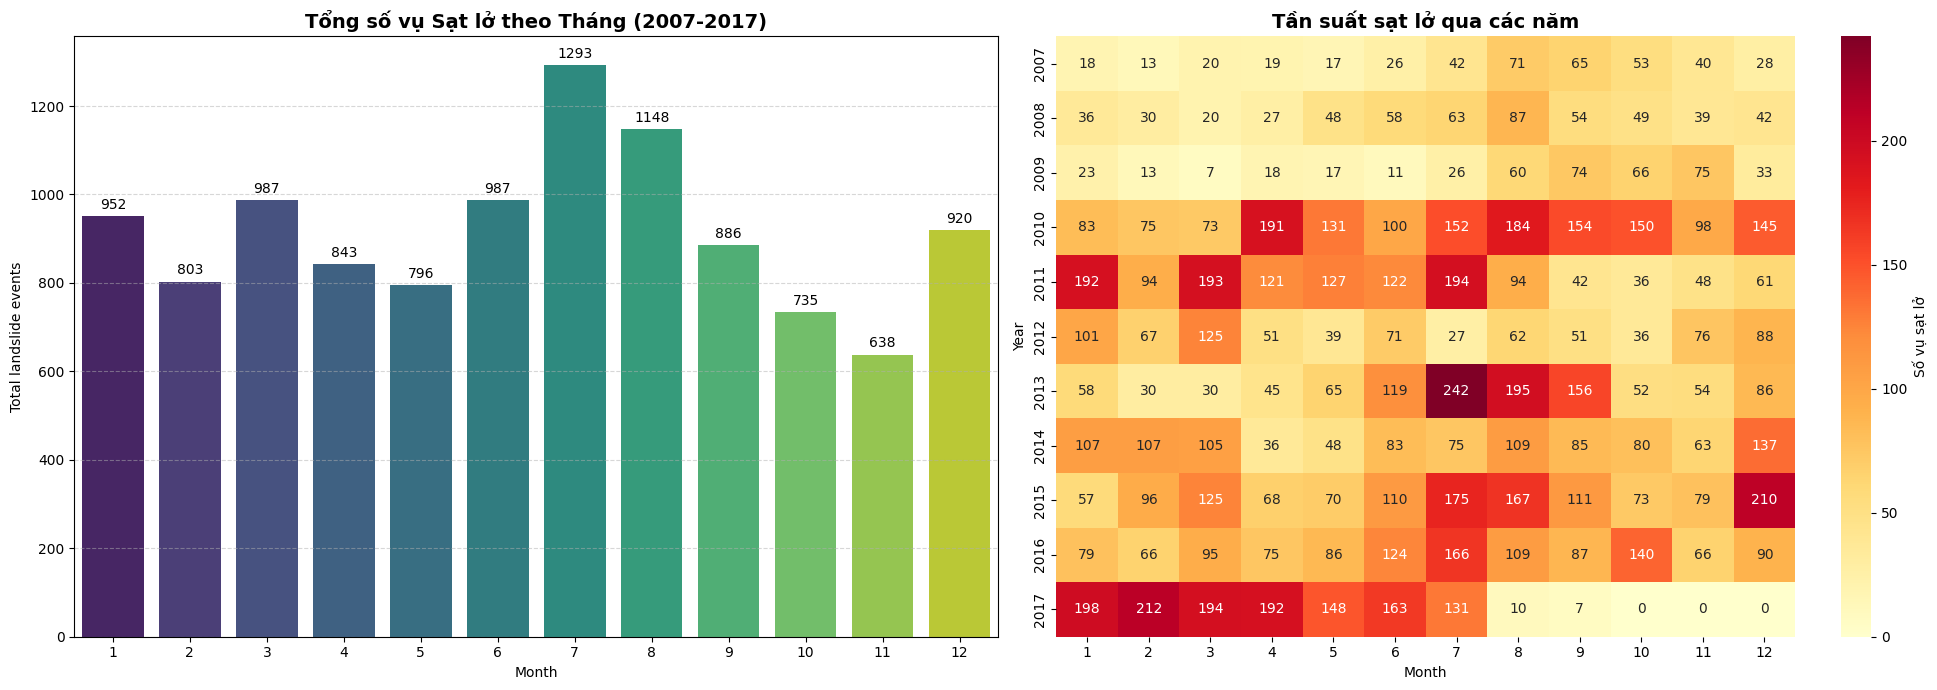

In [47]:
# Loại bỏ các dòng không có ngày tháng
df_time = df.dropna(subset=['event_date']).copy()

# Thống kê số vụ theo tháng
monthly_counts = df_time['month'].value_counts().sort_index()


# vẽ
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Biểu đồ 1: Phân bố theo Tháng (Barchart)
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Tổng số vụ Sạt lở theo Tháng (2007-2017)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total landslide events')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)



# Thêm nhãn giá trị
for container in axes[0].containers:
    axes[0].bar_label(container, padding=3)

# Biểu đồ 2: Heatmap Năm vs Tháng
# Tạo bảng Pivot: Hàng = Năm, Cột = Tháng, Giá trị = Số vụ
pivot_table = df_time.pivot_table(index='year', columns='month', values='event_id', aggfunc='count', fill_value=0)
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': 'Số vụ sạt lở'})
axes[1].set_title('Tần suất sạt lở qua các năm', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Year')
axes[1].set_xlabel('Month')


plt.tight_layout()
plt.show()

**Nhận xét**
- Nếu xét qua các năm, ta có thể thấy sạt lở có sự phân bố tập trung vào các tháng riêng biệt. Song ở trong vài năm số vụ diễn ra liên tiếp nhau trong nhiều tháng liền.
- Về tổng thể, số vụ sạt lở trên thế giới, ta vẫn chưa thể kết luận rằng sạt lở có sự phân bố theo mùa. Nhưng về mặt quan sát thì ở giai đoạn tháng 6,7,8 và giai đoạn cuối năm (12, 1) mang yếu tố mùa vụ rất cao trong trường hợp này, ta sẽ dựa trên các kết quả phân tích chi tiết hơn mới có thể kết luận một cách chính xác.
- Ngoài ra ta nhận ra có sự thay đổi, thời gian trước 2010 các vụ sạt lở trên thế giới xảy ra không nhiều ( < 90 vụ). Nhưng bắt đầu từ năm 2010, các vụ sạt lở xảy ra trên thế giới có sự thay đổi lớn:
    - Từ tháng 3/2010 - 8/2011: Trong suốt thời gian này các vụ sạt lở trên thế giới xảy ra liên tục, mỗi tháng đều có số vụ trung bình >100 vụ. Sau giai đoạn này trở về như trước năm 2010
    - 6/2013 - 9/2013: Đây là giai đoạn mà số vụ cao bất thường
    - 2015: Số vụ sạt lở có sự gia tăng trong năm này
    - 1/2017 - 7/2017: số vụ cao bất thường, có sự biến động lớn
    => Điều này làm ta càng chắc chắn hơn rằng có sự bất thường ở các năm 2010, 2013, 2015, 2017. Có thể là do khí hậu ảnh hưởng trên toàn thế giới hoặc một lý do nào khác? Ta sẽ tìm hiểu sâu hơn. 


#### **1.2 Có sự khác biệt giữa các vùng khí hậu hay không? Có theo tính mùa vụ hay không?**



**Cơ sở lý thuyết**\
Trên Trái Đất, mỗi vùng khí hậu khác nhau sẽ có một đặc điểm riêng biệt
- **Vùng nhiệt đới:**
    + Nóng quanh năm, nhiệt độ trung bình >18°C
    + Biên độ nhiệt ngày-đêm lớn hơn biên độ nhiệt năm
    + Lượng mưa rất cao; mùa mưa mùa khô rõ rệt
    + Khí hậu nóng ẩm; Rừng nhiệt đới phát triển mạnh; Bão nhiệt đới, lốc xoáy thường xuyên
- **Vùng cận nhiệt đới:**
    + Mùa hè nóng (trên 25°C), mùa đông ấm (10-20°C), hiếm khi có sương giá
    + Mưa theo mùa, thường mưa vào mùa hè, lượng mưa trung bình
    + Thảm thực vật đa dạng:
- **Vùng ôn đới:**
    + Bốn mùa rõ rệt: xuân, hạ, thu, đông; Biên độ nhiệt năm lớn, mùa đông lạnh
    + Lượng mưa phân bố đều quanh năm, lượng mưa trung bình 
    + Khí hậu ôn hòa, rừng lá rộng ôn đới, thảo nguyên, có thể có tuyết vào mùa đông
- **Vùng cận hàn đới:**
    + Mùa đông rất dài và lạnh giá; mùa hè ngắn, mát mẻ; đất đóng băng vĩnh cửu (permafrost) ở nhiều nơi
    + Lượng mưa thấp, chủ yếu là tuyết
    + Rừng lá kim chiếm ưu thế
- **Vùng hàn đới:**
    + Quanh năm dưới 0°C; cực lạnh vào mùa đông, mùa hè ngắn
    + Lượng mưa rất thấp, hầu hết là tuyết
    + Băng tuyết vĩnh cửu; thảm thực vật nghèo nàn

**Phương pháp:**
Dựa vào các đặc điểm khí hậu đó, ta sẽ phân tích xu hướng sạt lở của từng vùng khí hậu là như thế nào, đồng thời cũng giải thích được nguyên nhân xảy ra sạt lở.

In [48]:

# hàm phân vùng khí hậu (5 vùng)
def get_5_climate_zones(lat):
    # Trả về unknown nếu không có toạ độ
    if pd.isna(lat): 
        return 'unknown'
    
    # Lấy trị tuyệt đối để tính chung cho cả Bắc và Nam bán cầu
    abs_lat = abs(lat)
    
    if abs_lat <= 23.5:
        return 'tropical'      # 0 - 23.5
    elif abs_lat <= 35:
        return 'subtropical'   # 23.5 - 35
    elif abs_lat <= 60:
        return 'temperate'     # 35 - 60
    elif abs_lat <= 66.5:
        return 'subpolar'      # 60 - 66.5
    else:
        return 'polar'         # > 66.5

df['climate_zone'] = df['latitude'].apply(get_5_climate_zones)
df_climate = df[df['climate_zone'] != 'unknown'].copy()

**Lời dẫn**

Sau khi phân vùng khí hậu, ta xem xét phân bố của nó như thế nào.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4108\4001382410.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




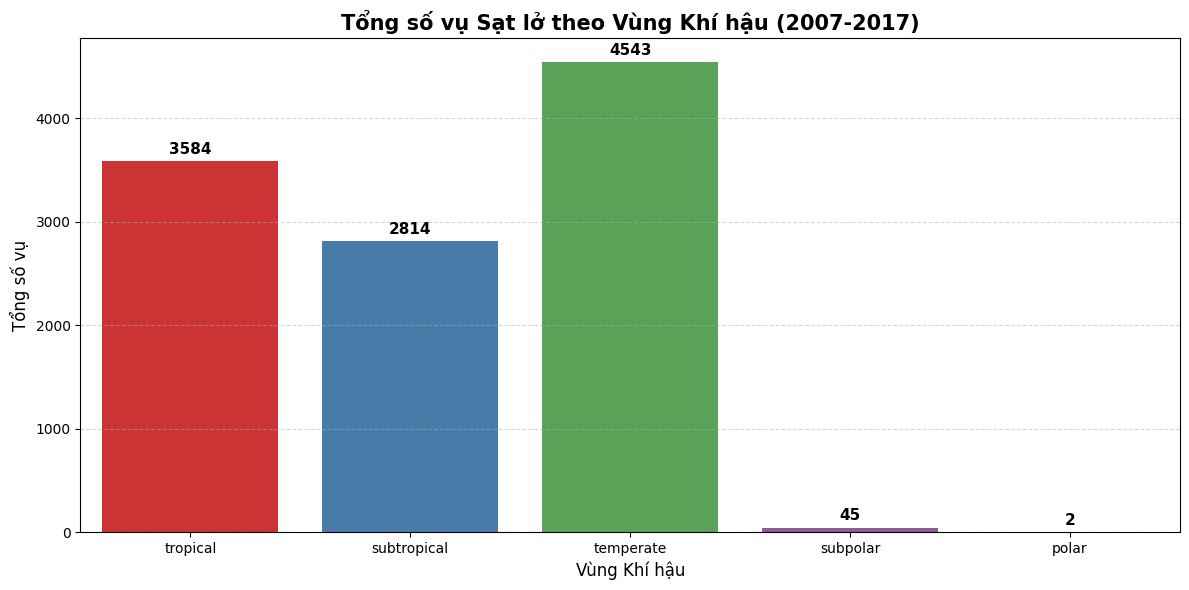

In [49]:
# Thứ tự hiển thị (từ xích đạo về cực)
order_zones = ['tropical', 'subtropical', 'temperate', 'subpolar', 'polar']
existing_order = [z for z in order_zones if z in df_climate['climate_zone'].unique()]

plt.figure(figsize=(12, 6))

sns.countplot(
    data=df_climate, 
    x='climate_zone', 
    order=existing_order, 
    palette='Set1'
)

# Trang trí
plt.title('Tổng số vụ Sạt lở theo Vùng Khí hậu (2007-2017)', fontsize=15, fontweight='bold')
plt.ylabel('Tổng số vụ', fontsize=12)
plt.xlabel('Vùng Khí hậu', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Thêm nhãn số lượng trên cột
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

**Nhận xét**
- Ta dễ dàng nhận thấy ở biểu đồ tổng số vụ sạt lở theo vùng khí hậu (2007 - 2017), số lượng sạt lở ở cả vùng cận hàn đới và hàn đới đều xảy ra rất ít. Ta có thể lý giải rằng vì ở 2 vùng đó dân cư thưa thớt không nhiều, thêm với việc môi trường khắc nghiệt khiến cho việc báo cáo về vụ sạt lở sẽ hạn chế. 

&emsp;=> Vì lý do trên nên nhóm đã quyết định ***không xét*** số trên cả vùng cận hàn đới và hàn đới.


**Lời dẫn**

Phân bố theo tháng và năm của từng vùng như thế nào? 

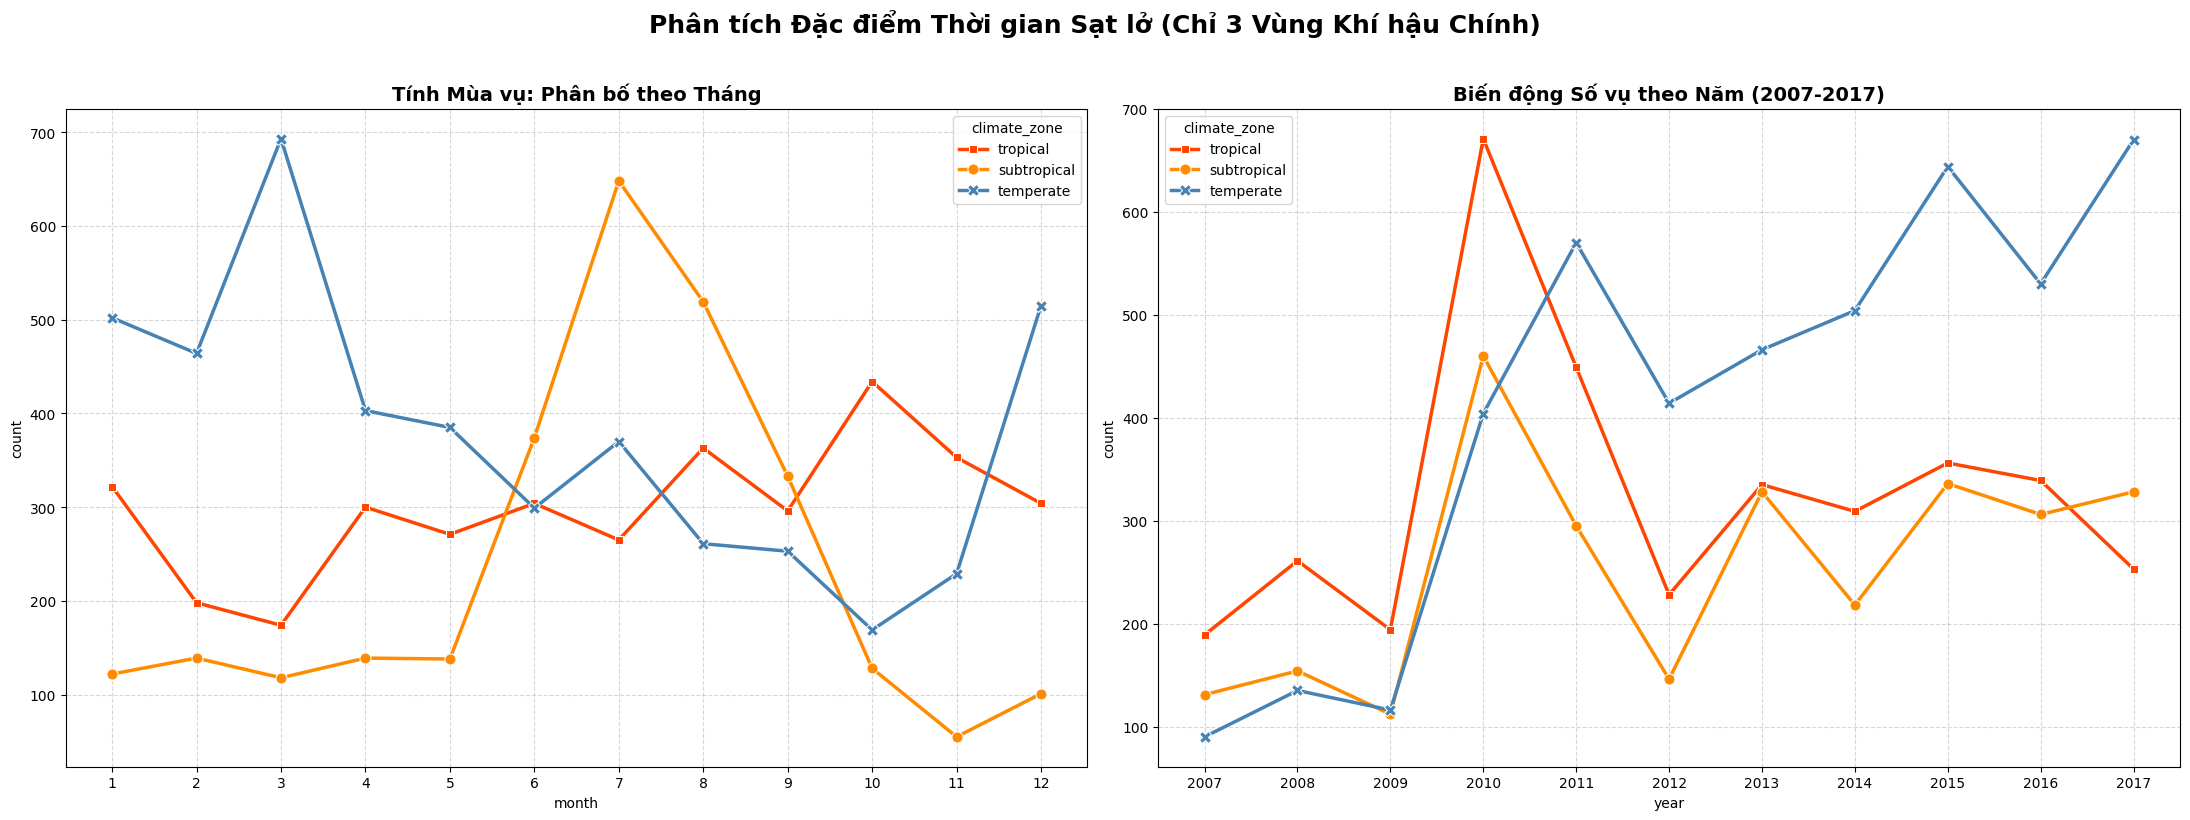

In [50]:

# Chỉ tập trung vào 3 vùng nhiệt đới, cận nhiệt đới và ôn đới
target_zones = ['tropical', 'subtropical', 'temperate']

# lọc bỏ Polar/Subpolar
df_filtered = df[df['climate_zone'].isin(target_zones)].copy()
df_filtered['climate_zone'] = df_filtered['climate_zone'].astype(str)

zone_monthly = df_filtered.groupby(['climate_zone', 'month']).size().reset_index(name='count')
yearly_counts = df_filtered.groupby(['year', 'climate_zone']).size().reset_index(name='count')

# vẽ biểu đồ 
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Màu sắc đồng nhất cho cả 2 biểu đồ
colors_map = {'tropical': '#FF4500', 'subtropical': '#FF8C00', 'temperate': '#4682B4'}

# BIỂU ĐỒ 1
sns.lineplot(
    data=zone_monthly, x='month', y='count', 
    hue='climate_zone', hue_order=target_zones, # Cố định thứ tự hiển thị
    palette=colors_map, style='climate_zone', 
    markers=True, markersize=8, dashes=False, linewidth=2.5, ax=axes[0]
)
axes[0].set_title('Tính Mùa vụ: Phân bố theo Tháng', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 13))
axes[0].grid(True, linestyle='--', alpha=0.5)

# BIỂU ĐỒ 2
sns.lineplot(
    data=yearly_counts, x='year', y='count', 
    hue='climate_zone', hue_order=target_zones,
    palette=colors_map, style='climate_zone', 
    markers=True, markersize=8, dashes=False, linewidth=2.5, ax=axes[1]
)
axes[1].set_title('Biến động Số vụ theo Năm (2007-2017)', fontsize=14, fontweight='bold')
axes[1].set_xticks(yearly_counts['year'].unique())
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Phân tích Đặc điểm Thời gian Sạt lở (Chỉ 3 Vùng Khí hậu Chính)', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Nhận xét**
- Trong biểu đồ Phân bố số vụ theo tháng của từng vùng khí hậu (2007 - 2017), ta thấy đã có sự phân bố rõ rệt:
    + **Ở vùng nhiệt đới:** Càng gần về cuối năm thì số vụ sạt lở lại có xu hướng tăng cao. Tháng 10 là tháng có số vụ cao nhất, đỉnh phụ là vào tháng 8. <br> 

        &emsp;=> Tháng 10 thường là cuối mùa mưa ở nhiều vùng nhiệt đới, khi đất đã bão hòa nước từ các tháng trước.Bão và áp thấp nhiệt đới hoạt động mạnh vào cuối mùa. Mưa lũ thường xảy ra. <br>
        &emsp;=> Tháng 8 là giữa mùa mưa

    + **Ở vùng cận nhiệt đới:** sạt lở phân bố rõ rệt, cao vào các tháng 6-7-8, tháng của những cơn mưa do có sự hoạt động của gió mùa. Đồng thời cũng là mùa bão nhiệt đới hoạt động mạnh.
    + **Ở vùng ôn đới:** Sạt lở xuất hiện nhiều vào tháng 12 và tháng 1 (có thể là do băng tan, tuyết tan), và đặc biệt có một dữ kiện khá là thú vị là ở tháng 3, số vụ trong vùng khí hậu này tăng cao thất thường không tuần theo mùa vụ.<br>
    &emsp;=> Chúng ta cần phân tích thêm để xem thử, liệu các nguyên nhân có thể gây ra ở các vùng này là như thế nào? 
- Trong biểu đồ Số vụ theo năm của 3 vùng khí hậu kể trên, ta có thể thấy:
    + Xu hướng chung của cả 3 vùng tăng rõ rệt qua các năm. Năm 2007 xấp xỉ 100 - 200 vụ/ vùng; Năm 2017 xấp xỉ 300 - 400 vụ/vùng. Tăng xấp xỉ 2-3 lần tổng số vụ trên toàn thế giới sau 10 năm
    + Tốc độ tăng khác nhau giữa mỗi vùng:  
        - Vùng nhiệt đới: Năm 2010 tăng mạnh nhất (đỉnh điểm gần 700 vụ), nhưng sau đó có xu hướng giảm qua các năm (giảm mạnh vào năm 2012), tuy có sự tăng nhẹ ở các năm 2013 và 2015 nhưng nhìn chung số vụ sạt lở đã giảm dần.
        - Vùng cận nhiệt đới: Xu hướng tương tự như vùng nhiệt đới, nhưng số vụ sạt lở nhìn chung ít hơn so với vùng nhiệt đới. 
        - Vùng ôn đới: tuy vào nằm 2010 thì vùng này có ít vụ hơn so với 2 vùng kể trên nhưng về tổng thể thì vùng này có xu hướng tăng ổn định qua các năm. Ta có thể thấy các đỉnh của nó là vào năm 2011, 2016, và tương lai (có thể là 2017). 
    + Một lần nữa cho thấy sự biến động về số vụ sạt lở qua các năm, cần chú ý các năm sau:
        - Các năm có số vụ tăng: 2010 (cả 3 vùng), 2011 (vùng ôn đới tăng cao nhất, nhưng lại giảm so với nhiệt đới và cận nhiệt đới), 2013 (cả 3 vùng), 2015, 2017 (vùng ôn đới vẫn tiếp tục tăng mặc dù 2 vùng kia đang xu hướng giảm)
        - Các năm yên tĩnh: 2012 (giảm sâu nhất ở cả 3 vùng), 2014 (giảm ở cả 2 vùng nhiệt đới và cận nhiệt đới)
    

**Giải thích hiện tượng**

Trước khi đi vào xem xét các hiện tượng nào đã diễn ra qua các năm trên ta sẽ phải nắm được kiến thức cơ bản về các hiện tượng khí hậu toàn cầu: 

**Cơ sở lý thuyết**
- El Nino là gì?
    + El Nino là một hiện tượng khí hậu tự nhiên xảy ra khi nhiệt độ bề mặt nước biển (Sea Surface Temperature – SST) ở vùng xích đạo trung tâm và phía đông Thái Bình Dương cao hơn mức trung bình nhiều năm.
    + Đặc điểm chính:
        + Nước biển ấm bất thường dọc theo xích đạo Thái Bình Dương
        + Gió mậu dịch (trade winds) suy yếu hoặc đảo chiều
        + Mưa lớn dịch chuyển về phía trung tâm – đông Thái Bình Dương
    + Hệ quả: Mưa lớn, lũ lụt ở Nam Mỹ (Peru, Ecuador); Hạn hán, nắng nóng ở Đông Nam Á, Australia; Thay đổi hoạt động bão ở nhiều lưu vực đại dương
- La Nina là gì? 
    + La Nina là hiện tượng khí hậu đối lập với El Niño, xảy ra khi SST ở vùng xích đạo trung tâm và đông Thái Bình Dương thấp hơn mức trung bình.
    + Đặc điểm chính:
        - Nước biển lạnh hơn bình thường ở xích đạo Thái Bình Dương
        - Gió mậu dịch mạnh hơn bình thường
        - Nước ấm bị đẩy mạnh về phía Tây Thái Bình Dương
    + Hệ quả khí hậu toàn cầu:
        - Mưa lớn, lũ lụt ở Đông Nam Á, Australia
        - Khô hạn ở bờ tây Nam Mỹ
- ENSO là gì? 
    + El Niño – Southern Oscillation (ENSO) là dao động khí hậu giữa hai pha:
        - El Nino — pha ấm: nhiệt độ nước biển (SST) ở vùng xích đạo Thái Bình Dương cao hơn bình thường.
        - La Nina — pha lạnh: SST thấp hơn bình thường.
        - ENSO còn đi kèm với thay đổi gió mậu dịch và vòng xoáy Walker, ảnh hưởng đến mưa, bão và nhiệt độ toàn cầu
    


**Các sự kiện qua các năm**
- 2009 - 2010: ENSO năm 2009–2010 ban đầu là El Nino vừa đến mạnh, sau đó hạ nhanh SST xuống dưới mức trung bình và tiến vào La Nina vào mùa hè – mùa thu 2010
- 2010 - 2012: sự kiện La Nina,bắt đầu từ giữa 2010 và là một trong những đợt La Niña mạnh nhất ghi nhận, gây ảnh hưởng cực đoan trên toàn cầu (lũ lụt Đông Australia, Thủy triều lớn Pakistan, hạn hán Đông Phi).
- 2012: Năm thời tiết cực đoan với nhiều siêu bão và lũ lụt
- 2013-2014: Các bất thường thời tiết và lượng mưa cực đoan trên nhiều châu lục.
- 2015–2016: là một trong những El Nino mạnh nhất thế kỷ 21, gây ra hàng loạt cực đoan khí hậu như hạn hán, lượng mưa bất thường và nhiệt độ cao trên toàn thế giới.
- 2017: Lũ lụt lớn ở Nam Mỹ (2016–2017): kéo dài từ cuối 2016 đến giữa 2017, đặc biệt ở Peru và Ecuador. Một năm của các siêu bão và hiện tượng thời tiết tàn phá: bao gồm Hurricane Harvey, Irma và Maria gây thiệt hại nặng ở Caribe và Hoa Kỳ; cháy rừng California, cùng nhiều cực đoan khí hậu khác.


**Đánh giá quan sát**

- Với 3 vùng, sạt lở có sự phân bố rõ rệt và theo mùa 
- Biến đổi khí hậu ở các giai đoạn các năm dẫn đến số vụ sạt lở có sự biến đổi lớn 
 

#### **1.3 Các vụ sạt lở có sự khác biệt giữa các khu vực địa lý hay không?**

**Phương pháp:**
Nghiên cứu được triển khai theo hướng từ tổng quát đến chi tiết. Trước hết, các vụ sạt lở được phân tích theo vùng khí hậu để xác định xu hướng chung. Tiếp theo, dữ liệu được phân tách theo các khu vực địa lý cụ thể, cho phép đánh giá sâu hơn sự khác biệt không gian của hiện tượng sạt lở đất và làm rõ vai trò của các điều kiện địa lý – tự nhiên đặc thù của từng khu vực.

Với mỗi khu vực địa lý sẽ có các kiểu khí hậu riêng, điều đó giúp ta có thể giải thích các hiện tượng sạt lở. Ta có bảng sau:

| Khu vực   | Các vùng khí hậu chủ yếu                                               |
|-----------|------------------------------------------------------------------------|
| Bắc Mỹ    | Ôn đới (chủ yếu), Cận nhiệt đới, Cận hàn đới                           |
| Nam Mỹ    | Nhiệt đới (chủ yếu), Cận nhiệt đới, Ôn đới                             |
| Châu Âu   | Ôn đới (chủ yếu), Cận hàn đới                                          |
| Châu Phi  | Nhiệt đới (chủ yếu), Cận nhiệt đới                                     |
| Nam Á     | Cận nhiệt đới (chủ yếu), Nhiệt đới, Ôn đới                             |
| Đông Á    | Cận nhiệt đới (chủ yếu), Ôn đới                                        |
| ĐNÁ và Úc | Nhiệt đới (chủ yếu), Cận nhiệt đới (không nhiều), Ôn đới (không nhiều) |

In [51]:
# Phân vùng địa lý
def get_geo_region(row):
    lat = row['latitude']
    lon = row['longitude']
    
    # Nếu thiếu toạ độ thì trả về unknown
    if pd.isna(lat) or pd.isna(lon):
        return 'unknown'

    # Châu Mỹ
    if lon < -30:
        if lat > 8:
            return 'north_america'  # Bao gồm Canada, Mỹ, Mexico, Trung Mỹ và Caribbean
        else:
            return 'south_america'   # Từ Colombia trở xuống
            
    # Châu Âu và Phi
    elif lon < 60:
        if lat > 30: return 'europe'
        else: return 'africa'
            
    # Châu Á và úc 
    else:
        if lon < 95: return 'south_asia'
        else:
            if lat > 25: return 'east_asia'
            else: return 'se_asia_oceania' # ĐNA và Úc 

df['region'] = df.apply(get_geo_region, axis=1) # tạo trường mời 


**Lời dẫn**

Ta sẽ kiểm tra xem phân bố của các vùng như thế nào.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4108\2242234597.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




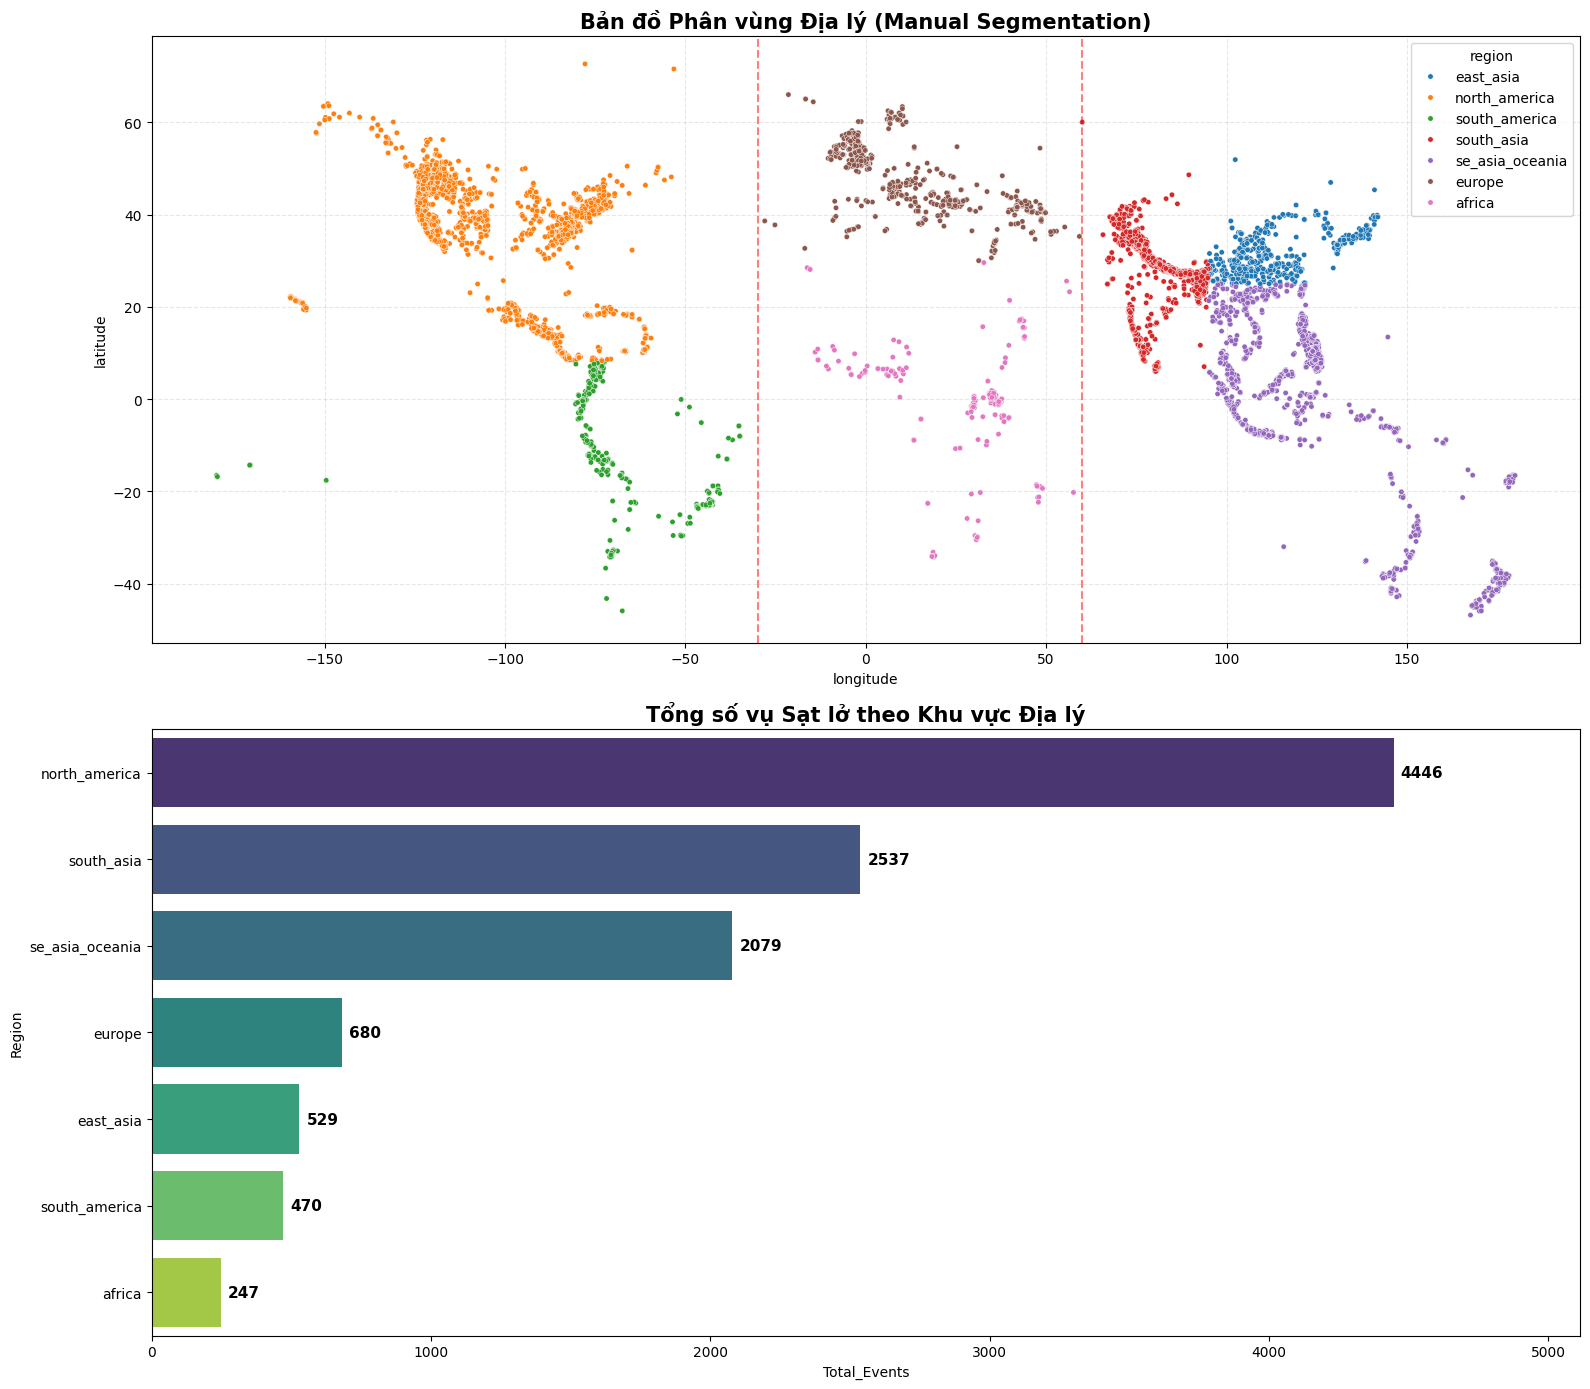

--- BẢNG THỐNG KÊ CHI TIẾT ---


Region  Total_Events  Percentage (%)
0    north_america          4446            40.5
1       south_asia          2537            23.1
2  se_asia_oceania          2079            18.9
3           europe           680             6.2
4        east_asia           529             4.8
5    south_america           470             4.3
6           africa           247             2.2

In [52]:
df_plot = df.dropna(subset=['region', 'month', 'latitude', 'longitude']).copy()

# Chuẩn bị dữ liệu 
region_counts = df['region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Total_Events']
region_counts = region_counts[region_counts['Region'] != 'unknown']

# Vẽ biểu đồ 
fig, axes = plt.subplots(2, 1, figsize=(16, 14))

# Biểu đồ 1: bản đô phân vùng địa lý (chủ yếu để xem xét toàn cục)
sns.scatterplot(
    data=df_plot, 
    x='longitude', y='latitude', 
    hue='region', palette='tab10', 
    s=15, ax=axes[0]
)
axes[0].set_title('Bản đồ Phân vùng Địa lý (Manual Segmentation)', fontsize=15, fontweight='bold')
axes[0].axvline(-30, color='red', linestyle='--', alpha=0.5) 
axes[0].axvline(60, color='red', linestyle='--', alpha=0.5)
axes[0].grid(True, linestyle='--', alpha=0.3)

# Biểu đồ 2: Tổng số vụ theo mỗi khu vực
sns.barplot(
    data=region_counts,
    y='Region', x='Total_Events',
    palette='viridis', ax=axes[1]
)
axes[1].set_title('Tổng số vụ Sạt lở theo Khu vực Địa lý', fontsize=15, fontweight='bold')
for container in axes[1].containers:
    axes[1].bar_label(container, padding=5, fontsize=11, fontweight='bold')
axes[1].set_xlim(0, region_counts['Total_Events'].max() * 1.15)

plt.tight_layout()
plt.show()

# 3. In bảng thống kê chi tiết
print("--- BẢNG THỐNG KÊ CHI TIẾT ---")
region_counts['Percentage (%)'] = (region_counts['Total_Events'] / region_counts['Total_Events'].sum()) * 100
display(region_counts.round(1))

**Nhận xét**
- Bắc Mỹ với tổng số vụ cao nhất với số vụ chiếm khoảng 40% trong tổng số vụ sạt lở (2007 - 2017)
- Châu Âu có số lượng thấp hơn rất nhiều so với top 3 => cần phân tích thêm
- Nam Mỹ với số lượng sạt lở ghi nhận thấp so với tiềm năng (dãy Andes dài nhất thế giới)
- Điều thú vị:
    + Dù cùng một châu lục nhưng có sự khác biệt rõ ràng giữa Bắc Mỹ và Nam Mỹ
    + Nam Á và Đông Á cũng xảy ra điều tương tự 
- Câu hỏi được đặt ra:
    + Tại sao lại có sự khác nhau lớn như vậy dựa trên điều thú vị mà ta khám phá?
    + Tại sao khu vực Bắc Mỹ lại có số vụ lớn hơn ~1.8 lần so với top 2?
    + Châu phi có số lượng ghi nhận các vụ sạt lở thấp nhất, Vì sao?
    + Liệu có sự thiếu báo cáo nào ở đây hay không? (dựa trên khu vực Nam Mỹ) <br>
    => Để biết được chi tiết hơn thì ta sẽ phân tích kĩ càng hơn

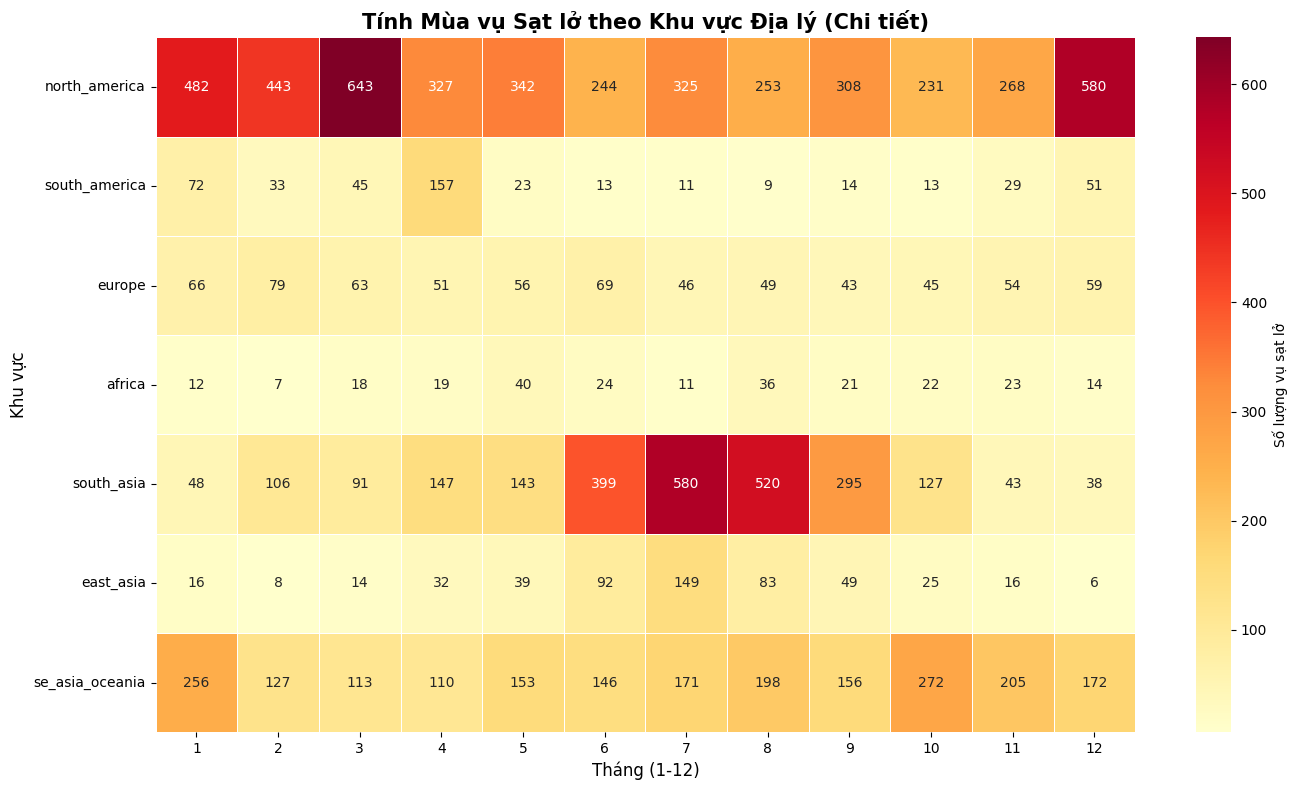

In [53]:
pivot_manual = df_plot.pivot_table(
    index='region', 
    columns='month', 
    values='event_id', 
    aggfunc='count'
).fillna(0)

# Sắp xếp thứ tự logic
ordered_regions = ['north_america', 'south_america', 'europe', 'africa', 'south_asia', 'east_asia', 'se_asia_oceania']
valid_order = [r for r in ordered_regions if r in pivot_manual.index]
pivot_manual = pivot_manual.loc[valid_order]

# 2. Vẽ biểu đồ heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_manual, 
    annot=True, 
    fmt='.0f', 
    cmap='YlOrRd', 
    linewidths=.5,
    cbar_kws={'label': 'Số lượng vụ sạt lở'}
)
plt.title('Tính Mùa vụ Sạt lở theo Khu vực Địa lý (Chi tiết)', fontsize=15, fontweight='bold')
plt.xlabel('Tháng (1-12)', fontsize=12)
plt.ylabel('Khu vực', fontsize=12)

plt.tight_layout()
plt.show()

**Nhận xét**
- Bắc Mỹ:
    + Tháng 3 với số vụ nhiều nhất. Ta còn có đỉnh phụ là tháng 12 
    + Mùa hè 6-7-8, số lượng sạt lở ít. Tập trung chủ yếu vào 12-1-2-3
- Nam Mỹ:
    + Các vụ được ghi nhận nhiều vào cuối năm từ tháng 12 tới tháng 4 
    + Xu hướng tương tự như ở Bắc Mỹ nhưng ít hơn rất nhiều
- Châu Âu:
    + Ít biến động giữa các tháng
    + Không thấy mùa rõ rệt
- Châu Phi:
    + Các sự kiện ít khi xảy ra ở khu vực này
    + 
- Nam Á:
    + Thấy được sự phân hoá theo mủa rõ rệt, tập trung vào 3 tháng chính là 6-7-8
    + Các tháng khác thì số vụ ít hơn rất nhiều
    + Biến động mạnh
- ĐNA và Úc: 
    + Ta thấy 2 đỉnh rõ ràng là tháng 10 và tháng 1
    + Số vụ diễn ra đều đặn quanh năm
    + Một phân do khí hậu mưa quanh năm
- Đông Á: 
    + Số vụ sạt lở được ghi nhận nhiều vào các tháng 6-7-8
    + Xu hướng tương tự như Nam Á nhưng số vụ được ghi nhận ở khu vực nào ít hơn rất nhiều
    + Biến động mạnh

=> Mỗi khu vực có một mùa riêng, không thể áp dụng các mô hình cảnh báo chung cho cả thế giới, phải áp dụng cho từng vùng. <br>
=> Nam Á có thể gọi là nơi xảy ra vụ sạt lở theo mùa rõ ràng nhất

**Lời dẫn**

Ta cùng xem xu hướng số vụ sạt lở của từng vùng có sự biến chuyển như thế nào.

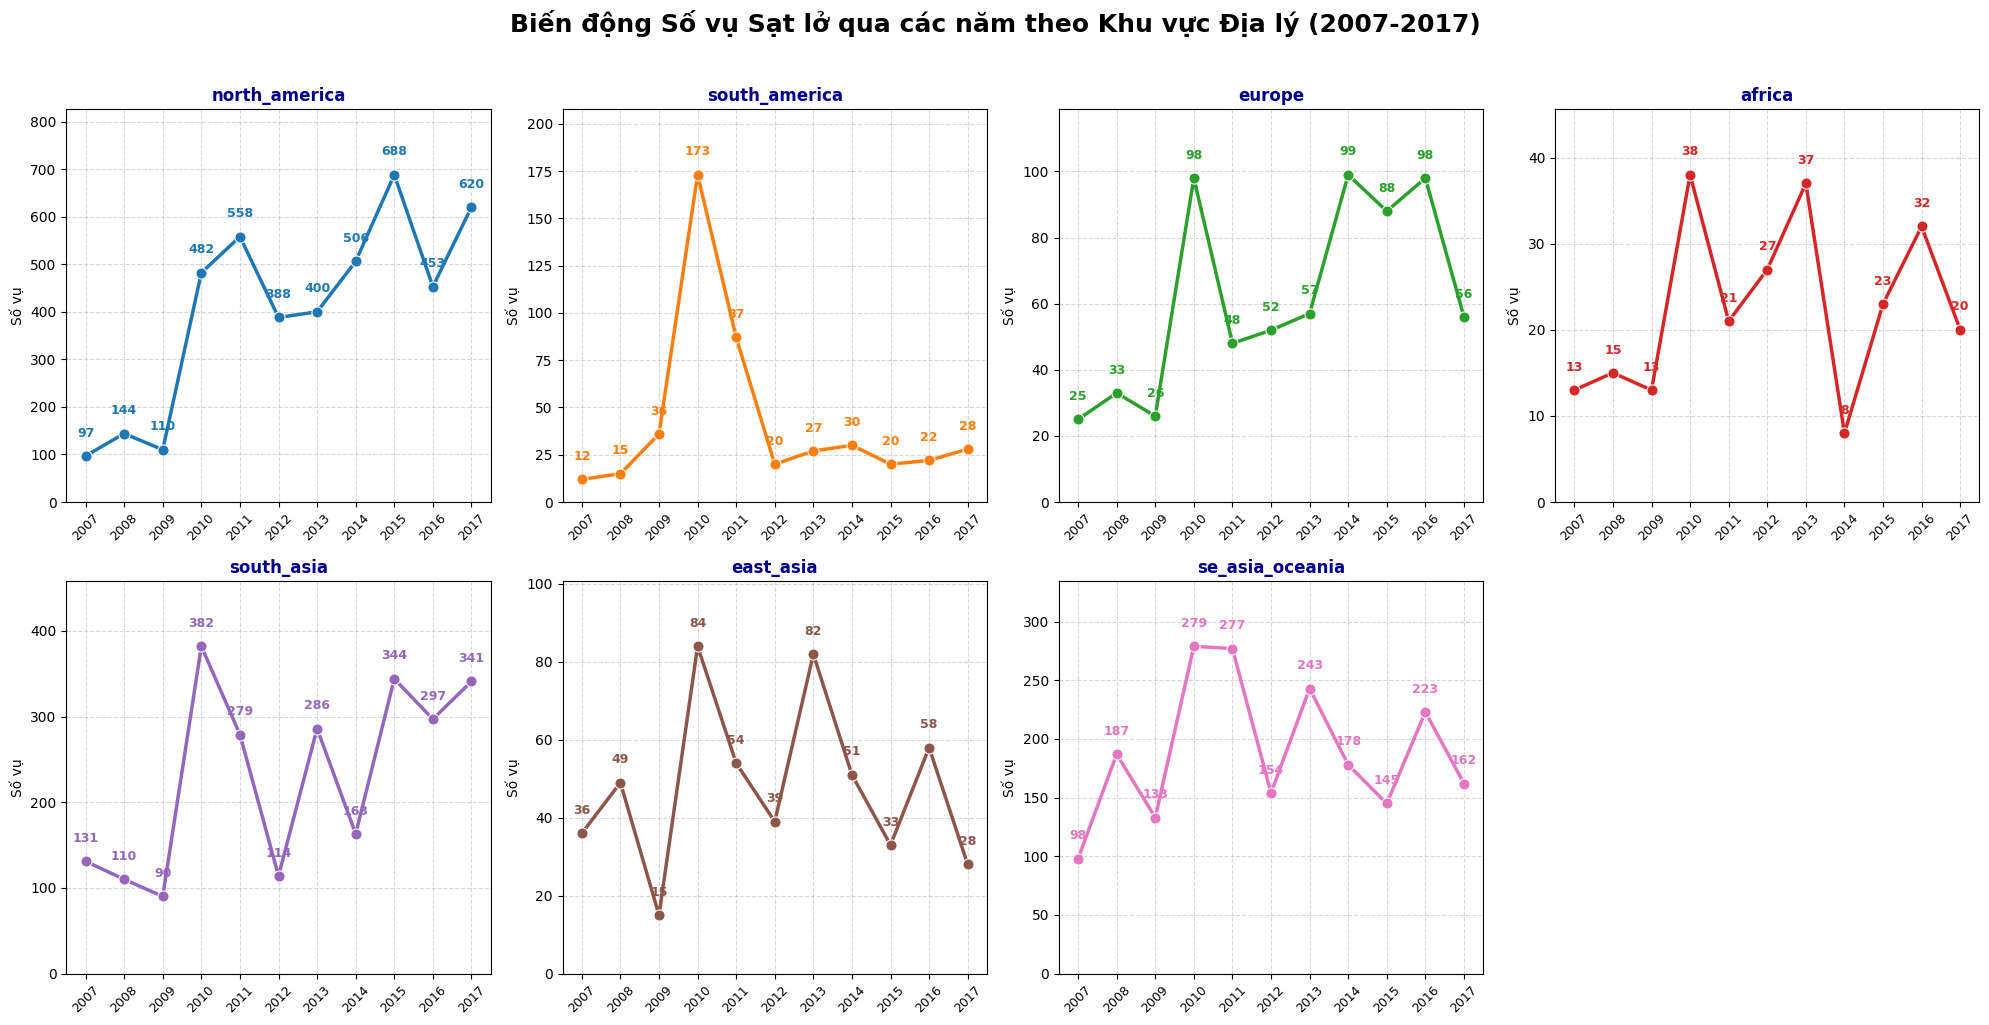

In [54]:

# Lọc dữ liệu sạch
df_trend = df.dropna(subset=['region', 'year']).copy()
# Chỉ lấy giai đoạn ổn định (ví dụ 2007-2017) để tránh các năm dữ liệu thiếu

valid_regions = [r for r in ordered_regions if r in df_trend['region'].unique()]

# Tính số vụ theo năm cho từng vùng
yearly_region_counts = df_trend.groupby(['region', 'year']).size().reset_index(name='count')

# 2. THIẾT LẬP SUBPLOTS
n_cols = 4
n_rows = math.ceil(len(valid_regions) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()
palette = sns.color_palette("tab10", len(valid_regions))

# 3. VẼ BIỂU ĐỒ
for i, region in enumerate(valid_regions):
    ax = axes[i]
    color = palette[i]
    
    # Lấy dữ liệu vùng
    data = yearly_region_counts[yearly_region_counts['region'] == region]
    
    # Vẽ Line plot
    sns.lineplot(
        data=data, 
        x='year', 
        y='count', 
        ax=ax, 
        color=color, 
        marker='o',       # Chấm tròn
        linewidth=2.5,    # Đường đậm
        markersize=8
    )
    
    # --- TRANG TRÍ ---
    ax.set_title(region, fontsize=12, fontweight='bold', color='darkblue')
    ax.set_xlabel('')
    ax.set_ylabel('Số vụ')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Hiển thị đủ các năm trên trục X (xoay 45 độ cho đỡ dính)
    ax.set_xticks(range(2007, 2018))
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    
    # QUAN TRỌNG: Hiển thị giá trị (số vụ) ngay trên điểm marker
    for x, y in zip(data['year'], data['count']):
        ax.text(x, y + (data['count'].max()*0.05), # Nhích lên trên điểm 1 chút
                f'{int(y)}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold', color=color)
        
    # Set giới hạn trục Y (để số không bị cắt)
    ax.set_ylim(0, data['count'].max() * 1.2)

# Xoá biểu đồ thừa
for j in range(len(valid_regions), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Biến động Số vụ Sạt lở qua các năm theo Khu vực Địa lý (2007-2017)', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

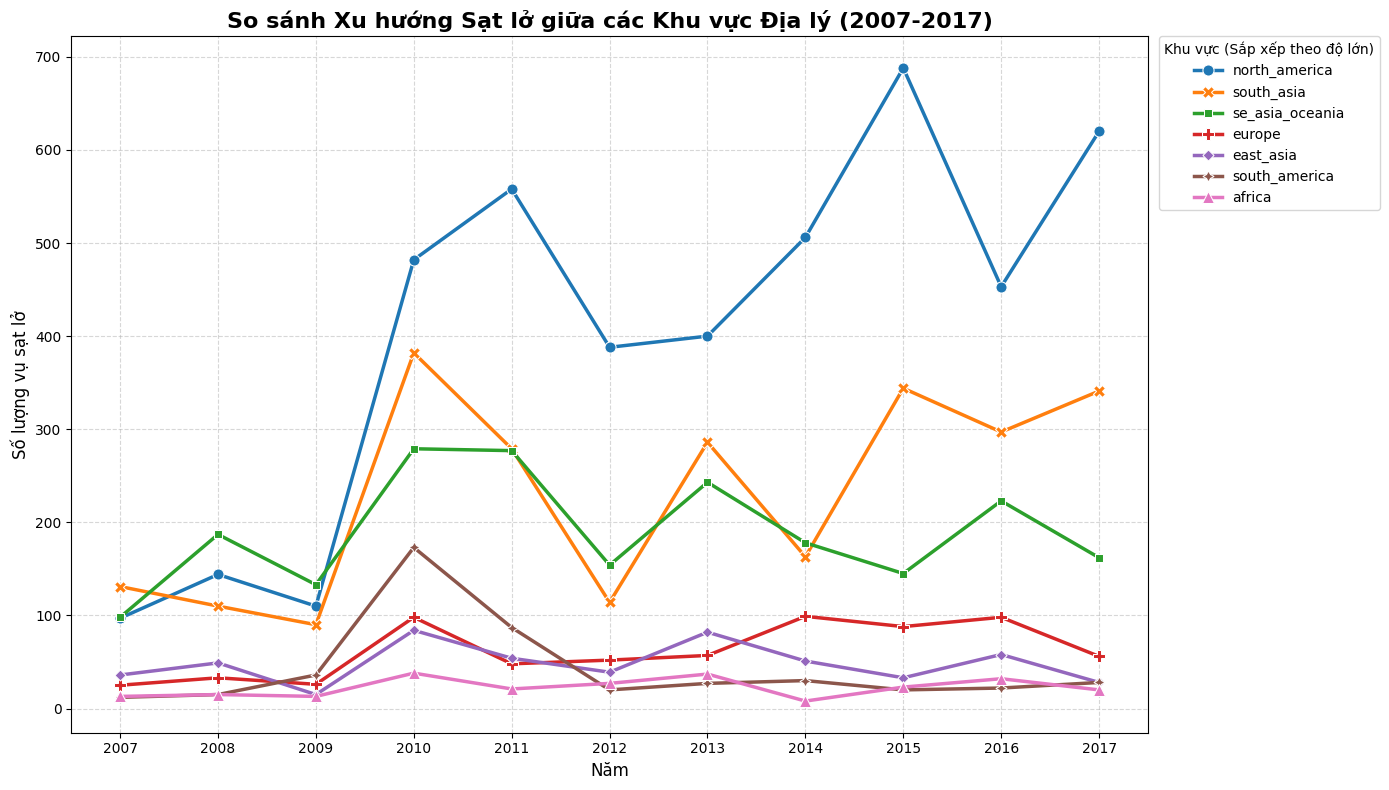

In [55]:

# Tính số vụ theo năm cho từng vùng
yearly_region_counts = df_trend.groupby(['region', 'year']).size().reset_index(name='count')

# Sắp xếp để vùng nào nhiều vụ nhất thì vẽ sau (nổi lên trên) hoặc gán màu nổi
total_counts = yearly_region_counts.groupby('region')['count'].sum().sort_values(ascending=False).index
yearly_region_counts['region'] = pd.Categorical(yearly_region_counts['region'], categories=total_counts, ordered=True)

# 2. VẼ BIỂU ĐỒ 
plt.figure(figsize=(14, 8))

sns.lineplot(
    data=yearly_region_counts, 
    x='year', 
    y='count', 
    hue='region', 
    style='region', 
    markers=True,   
    dashes=False,   
    linewidth=2.5,
    palette='tab10',
    markersize=8
)

# 3. TRANG TRÍ
plt.title('So sánh Xu hướng Sạt lở giữa các Khu vực Địa lý (2007-2017)', fontsize=16, fontweight='bold')
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Số lượng vụ sạt lở', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Hiện đủ năm trên trục X
plt.xticks(range(2007, 2018))

plt.legend(title='Khu vực (Sắp xếp theo độ lớn)', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

**Nhận xét**

Dựa trên 2 biểu đồ trên ta có nhận xét chung như sau:
- Bắc Mỹ có xu hướng tăng mạnh về số vụ sạt lở
- Nam Mỹ chỉ ghi nhận số vụ sạt lở cao trong 2010-2011, còn lại các năm có số vụ sạt lở ở mức thấp
- Nam Á có sự nhảy cảm mạnh khi có sự ảnh hưởng bởi các sự kiện khí hậu thế giới
- ĐNA và Úc có xu hướng giảm 
- Châu âu : xu hướng ổn định qua các năm
- Đông Á: Giống xu hướng ở khu vực ĐNA và Úc nhưng với số lượng các vụ thấp hơn
- Châu Phi: Số liệu ít

**Nhận định ban đầu**

Từng khu vực có số lượng sạt lở khác nhau, một phần là do nằm ở các vùng khí hậu khác nhau, một phần ta có thể liên hệ kiến thức thực tế ở mỗi khu vực sẽ có một địa hình khác nhau.

#### **1.4 Phân bố không gian của các vụ sạt lở có tập trung theo khu vực địa lý nhất định hay không?**

In [56]:


df_map = df[df['climate_zone'] != 'unknown'].copy()


climate_colors = {
    'tropical': '#FF3333',    # Đỏ tươi
    'subtropical': '#FFA500', # Cam
    'temperate': '#32CD32',   # Xanh lá
    'subpolar': '#00BFFF',    # Xanh dương sáng
    'polar': '#00008B',       # Xanh dương đậm
    'unknown': 'gray'
}

# 3. VẼ BIỂU ĐỒ VỚI MAPBOX
fig = px.scatter_mapbox(
    df_map,
    lat="latitude",
    lon="longitude",
    
    # --- QUAN TRỌNG: TÔ MÀU THEO KHÍ HẬU ---
    color="climate_zone", 
    
    # Gán bộ màu đã định nghĩa ở trên
    color_discrete_map=climate_colors,
    
    # Sắp xếp thứ tự trong chú thích (Legend) từ Nóng -> Lạnh
    category_orders={"climate_zone": ["tropical", "subtropical", "temperate", "subpolar", "polar"]},

    # --- CẤU HÌNH HIỂN THỊ ---
    hover_name="event_title",
    hover_data={
        "latitude": False,
        "longitude": False,
        "country_name": True,
        "climate_zone": True,  # Hiển thị thêm vùng khí hậu khi rê chuột
        "fatality_count": True,
    },
    
    # Chọn style bản đồ
    mapbox_style="open-street-map", 
    zoom=1, 
    height=850, 
    title="Bản đồ Phân bố Sạt lở theo 5 Vùng Khí hậu (Tropical -> Polar)"
)

# 4. TINH CHỈNH ĐIỂM DỮ LIỆU
fig.update_traces(
    marker=dict(
        size=6,             # Kích thước chấm
        opacity=0.7         # Độ trong suốt để thấy mật độ chồng lấn
    )
)

# 5. TINH CHỈNH LAYOUT
fig.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},
    legend=dict(
        title="Vùng Khí hậu",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255, 255, 255, 0.8)" # Nền trắng mờ cho khung chú thích dễ đọc
    )
)

fig.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4108\1068084374.py:14: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



**Nhận xét**

Theo quan sát trên bản đồ, ta thấy những nơi thường xảy ra sạt lở ở xung quanh các dãy núi cao, sườn núi.

**Các dãy núi/núi chính ở các khu vực địa lý:**
- Bắc Mỹ: Rocky Mountains, Cascade Range, Coastal Ranges, ...
- Nam Mỹ: Andes, ..
- Nam á: Himalaya, Hindu Kush,...
- Đông Á: Tây Tạng, Dãy núi Nhật Bản, 
- ĐNÁ và Úc: Central Cordillera (Philippines), Alps Nam (New Zealand), Barisan,....
- Châu Âu: Alps, Dãy núi Scandinavia,...

**Điều thú vị:** Ta quan sát thấy rằng vùng đất Nga rộng lớn như vậy nhưng số sự kiện sạt lở gần như là không có ghi nhận nào. 

#### **1.5 Tổng kết** 

**Kết luận:** Sạt lở đất - hiểm họa mang tính quy luật và biến động cực đoan

Sạt lở đất không phải là những sự kiện ngẫu nhiên mà là một hiểm họa có tính quy luật rõ rệt, bị chi phối bởi ba yếu tố cốt lõi: Thời gian (mùa vụ), Không gian (khí hậu/địa hình) và Chu kỳ khí hậu toàn cầu (ENSO).


**1. Quy luật phân bố theo Thời gian: Tính mùa vụ và Sự gia tăng dài hạn**

- Xu hướng dài hạn: Sạt lở có xu hướng gia tăng rõ rệt qua các năm. Tổng số vụ trên thế giới năm 2017 tăng gấp 2-3 lần so với năm 2007. Điều này cho thấy tác động ngày càng lớn của biến đổi khí hậu và các hiện tượng thời tiết cực đoan.
- Quy luật mùa vụ theo vùng khí hậu:
    + Vùng Nhiệt đới: Sạt lở tập trung mạnh vào tháng 10 (cuối mùa mưa, đất đã bão hòa nước) và tháng 8 (giữa mùa mưa).
    + Vùng Cận nhiệt đới: Đạt đỉnh vào các tháng 6, 7, 8 do ảnh hưởng trực tiếp của gió mùa và mùa bão.
    + Vùng Ôn đới: Quy luật khác biệt với đỉnh cao vào tháng 12 và tháng 1, liên quan đến hiện tượng tuyết tan và băng tan làm mất ổn định cấu trúc đất.
- Biến động bất thường: Các năm 2010, 2013, 2015 và 2017 ghi nhận số vụ cao đột biến, trùng khớp với các chu kỳ ENSO (El Nino và La Nina mạnh), gây ra lượng mưa cực đoan trên diện rộng.

**2. Quy luật phân bố theo Không gian: Địa hình và Vùng địa lý**

- Mối liên hệ với địa hình: Sạt lở phân bố tập trung xung quanh các dãy núi cao và sườn dốc lớn như: Himalayas (Nam Á), Andes (Nam Mỹ), Rocky Mountains (Bắc Mỹ) và Alps (Châu Âu). Những nơi có độ dốc lớn kết hợp với lượng mưa cao là "điểm nóng" của hiểm họa này.
- Sự khác biệt giữa các khu vực:
    + Bắc Mỹ: Chiếm tỷ trọng lớn nhất (~40% số vụ), tập trung vào các tháng đầu năm (tháng 3) và cuối năm (tháng 12).
    + Nam Á: Là khu vực có tính mùa vụ rõ rệt nhất thế giới, tập trung vào tháng 6-7-8 (mùa mưa gió mùa).
    + Đông Nam Á & Úc: Có quy luật "đa đỉnh" (tháng 10 và tháng 1) do đặc trưng khí hậu mưa dầm quanh năm.
    + Châu Phi & Nam Mỹ: Số lượng vụ ghi nhận thấp hơn dự kiến, cho thấy có sự thiếu hụt trong báo cáo dữ liệu tại các khu vực này dù tiềm năng rủi ro địa chất là rất lớn.

**3. Insight chính (Tổng kết cốt lõi)**
- "Cơ chế ngòi nổ": Sạt lở đất hoạt động theo cơ chế tích lũy và bùng phát. Lượng mưa không chỉ gây sạt lở tức thời (Downpour) mà còn có tác động tích lũy (đất bão hòa nước sau nhiều tháng mưa dầm), giải thích tại sao vùng Nhiệt đới thường sạt lở mạnh nhất vào cuối mùa mưa (tháng 10).
- Tác động kép của ENSO: Các hiện tượng khí hậu toàn cầu như El Nino và La Nina là "bộ khuếch đại" quy luật. Chúng làm thay đổi lượng mưa truyền thống, biến những vùng vốn yên bình trở thành điểm nóng sạt lở trong những năm cực đoan (như đỉnh điểm 2010, 2015).
- Sự bất đối xứng về dữ liệu: Việc Bắc Mỹ chiếm 40% số vụ trong khi Nam Mỹ (dãy Andes) hay Châu Phi có số liệu thấp cho thấy sạt lở là hiểm họa bị ảnh hưởng bởi năng lực quan trắc. Điều này gợi ý rằng rủi ro thực tế ở các nước đang phát triển có thể cao hơn rất nhiều so với những gì chúng ta thấy trên biểu đồ.
- Tính địa phương hóa: Không có một mô hình cảnh báo chung cho toàn cầu. Mỗi vùng khí hậu/địa lý có một "tháng tử thần" riêng, đòi hỏi các chính sách ứng phó phải được xây dựng dựa trên đặc thù khí hậu và địa hình của từng khu vực cụ thể.


### **2. Sạt lở đất được ghi nhận tập trung ở đâu? Sự phân bố này phản ánh chính xác nguy cơ tự nhiên hay bị ảnh hưởng bởi khả năng quan sát và báo cáo của con người?**

#### **2.1 Quốc gia nào ghi nhận nhiều sạt lở nhất trong giai đoạn 2007 - 2017**


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4108\1370022826.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




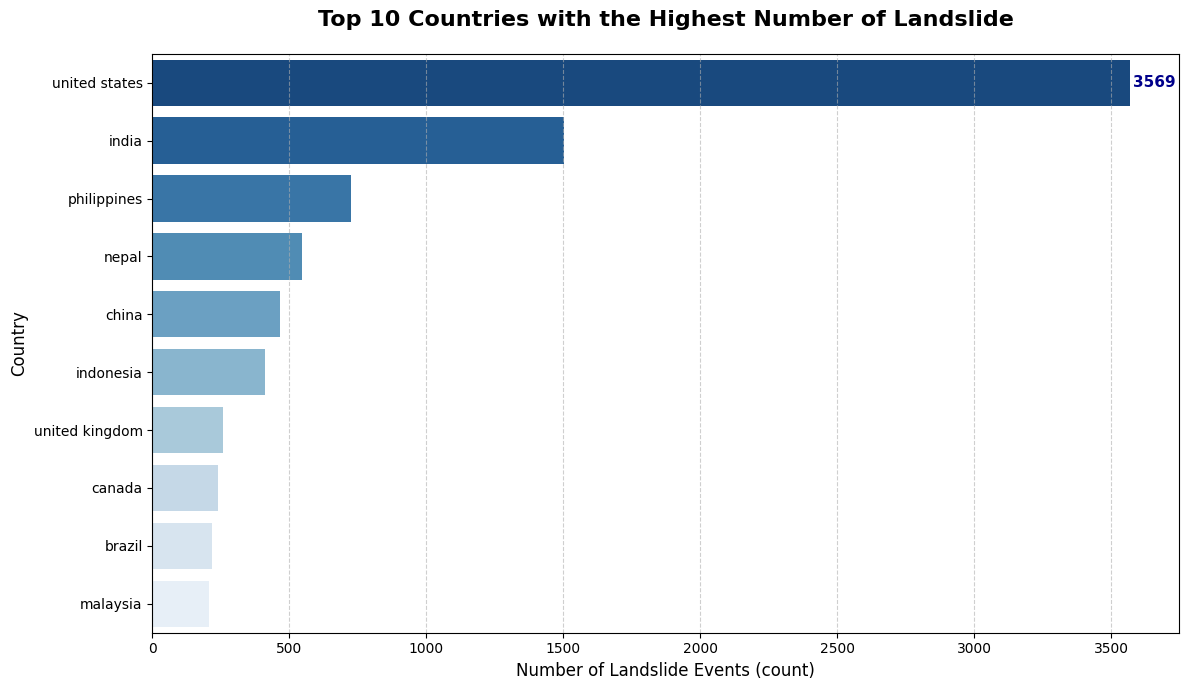

In [57]:

df_country = df[df['country_name'] != 'unknown'].copy()

# Top 10 nước nhiều vụ nhất
top_freq = df_country['country_name'].value_counts().head(10)

# Top 10 nước nhiều người chết nhất
top_fatal = df_country.groupby('country_name')['fatality_count'].sum().sort_values(ascending=False).head(10)

# Vẽ biểu đồ
plt.figure(figsize=(12, 7))

ax = sns.barplot(
    x=top_freq.values, 
    y=top_freq.index, 
    palette='Blues_r', 

)
ax.bar_label(ax.containers[0], padding=2, fontsize=11, fontweight='bold', color='darkblue')

plt.title('Top 10 Countries with the Highest Number of Landslide', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Landslide Events (count)', fontsize=12)
plt.ylabel('Country', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



**Nhận xét**

Ở Mỹ có số vụ cao ngất ngưỡng, gấp hơn 2 lần với top 2 là Ấn Độ

#### 2.2 Theo cấp đơn vị hành chính thì sao?


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4108\619583655.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




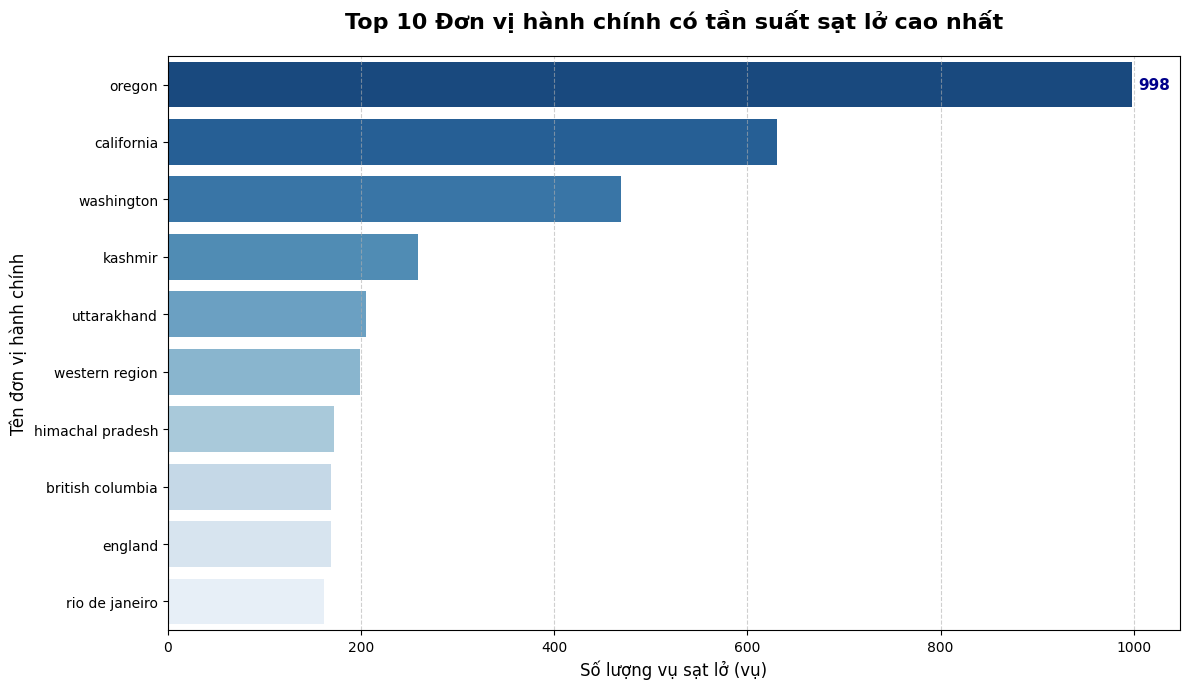

In [58]:
df_admin = df_country['admin_division_name']
top_admin_name = df_admin.value_counts().head(10)

plt.figure(figsize=(12, 7))

# 3. Vẽ biểu đồ thanh ngang

ax = sns.barplot(
    x=top_admin_name.values, 
    y=top_admin_name.index, 
    palette='Blues_r',
)
ax.bar_label(ax.containers[0], padding=5, fontsize=11, fontweight='bold', color='darkblue')

# 5. Trang trí tiêu đề và nhãn
plt.title('Top 10 Đơn vị hành chính có tần suất sạt lở cao nhất', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Số lượng vụ sạt lở (vụ)', fontsize=12)
plt.ylabel('Tên đơn vị hành chính', fontsize=12)

# Thêm lưới dọc để dễ so sánh độ dài
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Tối ưu hóa không gian
plt.tight_layout()
plt.show()

**Nhận xét**

- Ta để ý rằng ở các tiểu bang của Mỹ như là Oregon, Calìornia, Washington đều có só lượng vụ sạt lở cao được ghi nhận từ 2007 - 2017
- Ta đặt nên nghi vấn là do ở đây có hiện địa hình phức tạp nên diễn ra nhiều sự kiện hay chỉ là do hệ thống báo cáo của những tiểu bang này hoạt động tích cực hơn những nơi khác? Trong khi khu vực xung quanh dãy Himalaya lại có số vụ ghi nhận tương đối mặc dù là một trong những dãy núi lớn trên thế giới.


#### **2.3 Liệu sự phân bố sạt lở quan sát được phản ánh hiện tượng tự nhiên hay thiên lệch do nguồn thu thập dữ liệu?**


**Lời dẫn**

Ta sẽ xem xét các nguồn thông tin báo cáo về các sự kiện này có sự khác biệt gì hay không.

In [59]:
# 1. Tính toán cơ bản
total_events = len(df)  # Tổng số vụ trong toàn bộ dữ liệu
source_counts = df['source_name'].value_counts() # Đếm số lượng từng nguồn

# 2. Lấy Top 10 và tính phần trăm
top_10_sources = source_counts.head(10)
top_10_pct = (top_10_sources / total_events) * 100

# 3. Tạo DataFrame đẹp để hiển thị bảng
stats_df = pd.DataFrame({
    'Source Name': top_10_sources.index,
    'Event Count': top_10_sources.values,
    'Contribution (%)': top_10_pct.values
})


# --- IN KẾT QUẢ THỐNG KÊ ---
print("--- BẢNG THỐNG KÊ CHI TIẾT ---")
display(stats_df)



--- BẢNG THỐNG KÊ CHI TIẾT ---


Source Name  Event Count  Contribution (%)
0           Oregon DOT          768          6.989443
1      maps.google.com          104          0.946487
2    thehimalayantimes           75          0.682563
3       news.xinhuanet           74          0.673462
4    newsinfo.inquirer           71          0.646159
5       thejakartapost           59          0.536949
6           ibnlive.in           57          0.518748
7       Times of India           47          0.427739
8     The Jakarta Post           46          0.418639
9  The Himalayan Times           43          0.391336

**Số nguồn ghi nhận các sự kiện**

In [60]:
df['source_name'].nunique()

3912

**Nhận xét**

Ta để ý rằng có một nguồn có số lượt ghi nhận cao hơn rất nhiều so với các nguồn khác. Đó là Oregon DOT (Sở Giao thông Vận tải của bang Oregon, cơ quan nhà nước chịu trách nhiệm quản lý, vận hành và phát triển hệ thống giao thông trong phạm vi bang Oregon) chiếm tới gần 7% so với các nguồn khác (chủ yếu < 1%).


Ta cùng kiểm tra nhỏ xem ở những nguồn này thì landslide_size của nó như thế nào (Được biết, cơ quan ở tiêu bang này ghi nhận tất cả các hiện tượng sạt lở trên khu vực của tiểu bang dù lớn hay nhỏ, nếu ta tìm được quy luật hay điều gì đó cũng có thể chứng minh được rằng tuy ở Mỹ có nhiều vụ sạt lở không phải do có địa hình phức tạp hay khí hậu thất thường, mà chủ yếu là do sự hoạt động tích cực của cơ quan ở nơi đây trong việc ghi nhận sự việc)

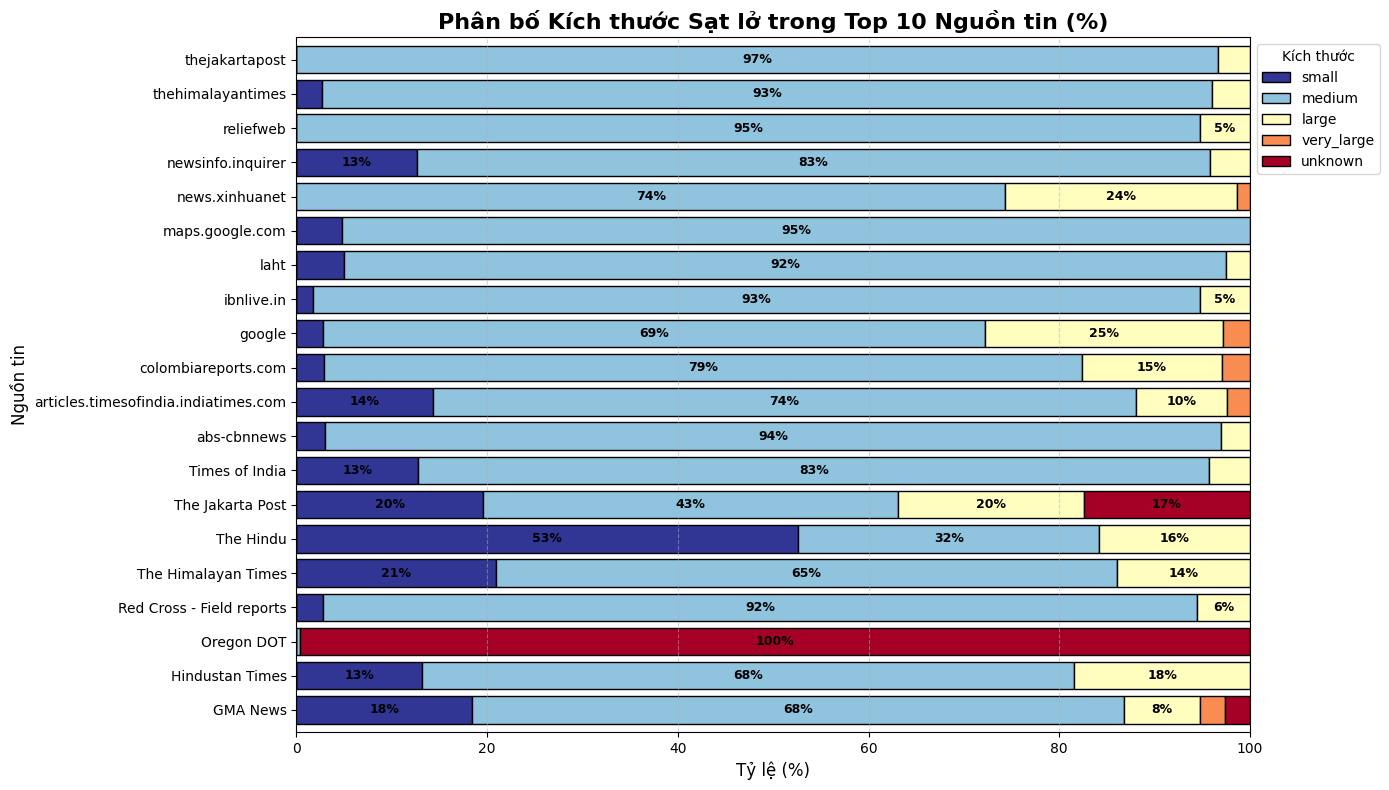

In [61]:

# 1. Lọc dữ liệu Top 10 nguồn tin
top_10_sources = df['source_name'].value_counts().head(20).index
df_top_source = df[df['source_name'].isin(top_10_sources)].copy()

# 2. Xử lý dữ liệu Landslide Size (nếu chưa chuẩn hoá)
# Chuyển về chữ thường và thay thế NaN bằng 'unknown'
df_top_source['landslide_size'] = df_top_source['landslide_size'].fillna('unknown').astype(str).str.lower().str.strip()

# 3. Tạo bảng chéo (Crosstab) và Chuẩn hóa theo hàng (index) để ra %
# normalize='index' giúp biến đổi số lượng thành tỷ lệ phần trăm (tổng hàng ngang = 100%)
size_distribution = pd.crosstab(
    df_top_source['source_name'], 
    df_top_source['landslide_size'], 
    normalize='index'
) * 100


# Sắp xếp lại thứ tự cột kích thước cho logic (Nhỏ -> Lớn)
# Lưu ý: Bạn kiểm tra lại các giá trị size thực tế trong data của bạn để khớp tên
desired_order = ['small', 'medium', 'large', 'very_large', 'unknown']
# Chỉ lấy những cột có tồn tại trong dữ liệu
existing_order = [size for size in desired_order if size in size_distribution.columns]
size_distribution = size_distribution[existing_order]

# 4. Trực quan hoá: Stacked Bar Chart 100%
ax = size_distribution.plot(
    kind='barh', 
    stacked=True, 
    figsize=(14, 8), 
    colormap='RdYlBu_r', # Màu từ Xanh (Nhỏ/An toàn) sang Đỏ (Lớn/Nguy hiểm)
    edgecolor='black',
    width=0.8
)

# 5. Thêm nhãn % lên biểu đồ (Chỉ hiện nếu > 5% để đỡ rối)
for c in ax.containers:
    labels = [f'{v.get_width():.0f}%' if v.get_width() > 5 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9, fontweight='bold', color='black')

plt.title('Phân bố Kích thước Sạt lở trong Top 10 Nguồn tin (%)', fontsize=16, fontweight='bold')
plt.xlabel('Tỷ lệ (%)', fontsize=12)
plt.ylabel('Nguồn tin', fontsize=12)
plt.legend(title='Kích thước', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Nhận xét**

**1. Bằng chứng về sự thiên lệch**

Thiên lệch báo cáo xảy ra khi khả năng một sự kiện được ghi nhận phụ thuộc vào vị trí của nó (nước giàu vs nước nghèo, ngôn ngữ tiếng Anh vs ngôn ngữ khác).

- Bằng chứng 1: Sự thống trị của các nguồn tin địa phương.

    + Trong bộ dữ liệu NASA này, có một nguồn tin cực kỳ chăm chỉ là Oregon DOT. Họ báo cáo cả những vụ sạt lở nhỏ xíu trên đường cao tốc.

    + Kết quả: Bang Oregon (Mỹ) có số vụ sạt lở cao một cách vô lý so với các vùng núi hiểm trở khác trên thế giới.

- Bằng chứng 2: Kích thước sạt lở

    + Ở những nơi khác như ở Châu Á, khi có sự việc xảy ra ở mức độ medium trở lên thì được ghi nhận nhiều hơn là small.
    + Chỉ riêng ở tiểu bang Oregon thì tất cả là Unknown, dù cho có số lượng ghi nhận nhiều đến vậy

**2. Luận điểm: Bằng chứng về Tự nhiên**
   
Mặc dù số lượng bị thiên lệch, nhưng dữ liệu vẫn tuân theo các quy luật vật lý:

- Tính mùa vụ: như đã trình bày ở câu hỏi trước, sạt lở tăng vọt vào mùa mưa/bão. Đây là tín hiệu tự nhiên không thể làm giả.

- Địa hình: Dù số liệu ở Nepal/Andes có thể bị thiếu, nhưng những vụ được ghi nhận đều nằm ở vùng núi dốc, phù hợp với kiến thức địa lý.

#### **2.4 Có những khu vực nào ghi nhận sạt lở lặp đi lặp lại nhiều lần trong 10 năm không?**

**Lời dẫn**

Biết được có sự thiên kiến trong báo cáo, chúng ta sẽ xét trên 2 vùng khác nhau: các vùng trừ Mỹ và Mỹ


In [62]:
# 1. Gom nhóm theo Quốc gia & Tỉnh/Bang
admin_repeat = df.groupby(['country_name', 'admin_division_name']).agg(
    total_events=('event_id', 'count'),            # Tổng số vụ
    total_deaths=('fatality_count', 'sum'),        # Tổng số chết
    unique_years=('event_date', lambda x: x.dt.year.nunique()), # Số năm có sạt lở (Max = 11)
    first_year=('event_date', lambda x: x.dt.year.min()),
    last_year=('event_date', lambda x: x.dt.year.max())
).reset_index()

# 2. Tính Tần suất trung bình (Vụ/Năm hoạt động)
admin_repeat['events_per_active_year'] = (admin_repeat['total_events'] / admin_repeat['unique_years']).round(1)

# 3. Lọc & Sắp xếp
# Chỉ lấy những nơi có ít nhất 10 vụ để xem xét tính lặp lại
top_repeat = admin_repeat[admin_repeat['total_events'] >= 0].sort_values('total_events', ascending=False)

# --- TÁCH RIÊNG MỸ VÀ THẾ GIỚI (Để tránh Oregon chiếm sóng) ---
us_stats = top_repeat[top_repeat['country_name'] == 'united states']
world_stats = top_repeat[top_repeat['country_name'] != 'united states']

# --- HIỂN THỊ KẾT QUẢ ---
cols_show = ['country_name', 'admin_division_name', 'unique_years', 'events_per_active_year']

print("--- TOP 10 KHU VỰC XẢY RA NHIỀU NHẤT THẾ GIỚI (TRỪ MỸ) ---")
print("Tiêu chí: Số năm xảy ra sạt lở cao và Tổng số vụ lớn")
display(world_stats[cols_show].head(10))

print("\n--- TOP 5 KHU VỰC LẶP LẠI NHIỀU NHẤT TẠI MỸ ---")
display(us_stats[cols_show].head(10))

--- TOP 10 KHU VỰC XẢY RA NHIỀU NHẤT THẾ GIỚI (TRỪ MỸ) ---
Tiêu chí: Số năm xảy ra sạt lở cao và Tổng số vụ lớn


country_name               admin_division_name  unique_years  \
372           india                           kashmir            10   
393           india                       uttarakhand            11   
619           nepal                    western region            11   
368           india                  himachal pradesh            11   
903  united kingdom                           england            11   
118          canada                  british columbia            11   
85           brazil                    rio de janeiro             8   
614           nepal                    central region            11   
725     philippines  cordillera administrative region             7   
421       indonesia                         west java            11   

     events_per_active_year  
372                    25.9  
393                    18.6  
619                    16.8  
368                    15.6  
903                    15.4  
118                    15.4  
85                     20.2  
614                    11.3  
725                    17.3  
421                    10.1


--- TOP 5 KHU VỰC LẶP LẠI NHIỀU NHẤT TẠI MỸ ---


country_name admin_division_name  unique_years  events_per_active_year
942  united states              oregon            11                    90.7
912  united states          california            11                    57.4
951  united states          washington            11                    42.6
913  united states            colorado            11                    14.5
923  united states            kentucky            11                    13.9
943  united states        pennsylvania            11                    11.7
952  united states       west virginia            11                    11.1
948  united states                utah            10                     9.5
918  united states               idaho            10                     8.5
938  united states      north carolina            10                     7.4

**Nhận xét**

Ta thấy ở những nơi khác ngoài Mỹ, ta cần tập trung chú ý vào Châu á, đặc biệt là các quốc gia ở gần dãy Himalaya với tần xuất xảy ra sạt lỡ thường xuyên theo các năm, cũng như là các quốc gia là thuộc đảo và quần đào có địa hình núi cao chiến phần lớn


#### **2.5 Tổng kết**

**Kết luận:** Sự phân bố sạt lở đất trên bản đồ dữ liệu toàn cầu hiện nay là một bức tranh "không đối xứng". Nó vừa phản ánh chính xác các vùng có nguy cơ tự nhiên (địa hình dốc, mùa mưa), vừa bị khuếch đại hoặc thu nhỏ bởi khả năng quan sát và báo cáo của con người.

**a. Sạt lở đất được ghi nhận tập trung ở đâu?**

- Hoa Kỳ dẫn đầu về số lượng: Số vụ sạt lở tại Mỹ cao gấp hơn 2 lần so với quốc gia đứng thứ hai là Ấn Độ.
- Tập trung tại các tiểu bang miền Tây nước Mỹ: Oregon, California và Washington là những nơi có số lượng vụ sạt lở được ghi nhận cao nhất trong giai đoạn 2007 - 2017.
- Khu vực Châu Á trọng điểm: Các quốc gia gần dãy Himalaya và các đảo quốc có địa hình núi cao là những nơi có tần suất xảy ra sạt lở thường xuyên theo năm.
  
**b. Ảnh hưởng của khả năng quan sát và báo cáo**

Sự tập trung cao độ tại Mỹ không hoàn toàn đồng nghĩa với việc đây là nơi nguy hiểm nhất thế giới, mà chủ yếu do hệ thống ghi nhận hoạt động cực kỳ hiệu quả:
- Sự thống trị của các nguồn tin chuyên biệt: Cơ quan Oregon DOT (Sở Giao thông Vận tải bang Oregon) chiếm tới gần 7% tổng số vụ ghi nhận toàn cầu, vượt xa các nguồn tin khác (thường chỉ chiếm dưới 1%).
- Chính sách ghi nhận bao phủ: Tại các bang như Oregon, mọi hiện tượng sạt lở dù lớn hay nhỏ, dù quy mô chỉ là sạt trượt nhẹ trên đường cao tốc, đều được báo cáo và đưa vào dữ liệu.
- Thiên lệch về kích thước (Landslide Size): * Ở Châu Á, chỉ những vụ sạt lở quy mô từ Trung bình (Medium) trở lên mới thường xuyên được ghi nhận do tính chất tàn phá lớn thu hút báo chí.
    + Ở Mỹ (đặc biệt là Oregon), số lượng vụ rất lớn nhưng phần lớn kích thước được ghi là Unknown (Không xác định), cho thấy sự tích cực trong việc báo cáo mọi biến động địa chất bất kể quy mô.

**c. Những quy luật tự nhiên vẫn được khẳng định**

Mặc dù bị ảnh hưởng bởi thiên lệch báo cáo, dữ liệu vẫn chứng minh được các quy luật vật lý khách quan:
- Tính mùa vụ: Sạt lở vẫn tăng vọt vào mùa mưa và bão theo đúng quy luật khí hậu của từng vùng. Đây là tín hiệu tự nhiên trung thực mà hệ thống báo cáo không thể làm giả.
- Mối liên hệ với địa hình: Dù số liệu ở các nước đang phát triển (như Nepal hay các nước vùng Andes) có thể bị thiếu hụt, nhưng những vụ được ghi nhận đều nằm chính xác tại các vùng núi dốc, phù hợp với kiến thức địa lý tự nhiên.
  
**d. Insight chính**

Sự phân bố sạt lở toàn cầu phản ánh một thực tế bị "bóp méo" bởi hạ tầng thông tin:
- Năng lực báo cáo tạo ra sự chênh lệch: Con số cao ngất ngưỡng tại Mỹ (Oregon, California, Washington) phản ánh sự tích cực của con người trong việc quản lý hạ tầng giao thông hơn là sự thất thường của địa hình hay khí hậu.
- Nguy cơ thực tế nằm ở Châu Á: Dãy Himalaya và các quốc gia quần đảo núi cao vẫn là những vùng rủi ro tự nhiên cao nhất. Sự thiếu hụt số liệu ở đây so với Mỹ là do hạn chế về nguồn lực báo cáo chứ không phải do an toàn hơn.
- Bản chất dữ liệu: Dữ liệu sạt lở đất hiện nay là sự kết hợp giữa vị trí địa lý rủi ro (núi cao, độ dốc) và trình độ kinh tế - xã hội (năng lực báo cáo, ngôn ngữ). Người làm khoa học dữ liệu cần bóc tách được "nhiễu" báo cáo để xác định đúng trọng tâm rủi ro thiên tai thực sự.

### **3. Mối quan hệ nhân - quả trong thảm họa sạt lở đất là gì? Các loại hình và nguyên nhân sạt lở cụ thể nào, dẫn đến hậu quả nghiêm trọng nhất về mặt con người, và chúng phân bố ở đâu?**
- Như đã quan sát ở phần Khám phá dữ liệu. Ta đã biết nguyên nhân gây ra sạt lở hàng đầu là downpour và loại sạt lở phổ biến là sạt lở đất.
- Ở phần này ta sẽ phân tích sâu vào ở khu vực nào sẽ là loại nào chiếm ưu thế, nguyên nhân là do đâu
- Tiếp ta sẽ phân tích về số người chết, nơi nào cần được quan tâm đặc biệt, loại sạt lở nào cần chú ý cao và nguyên nhân là do đâu để đề phòng hợp lý.

#### **3.1 Mỗi vùng sẽ được đặc trưng bởi loại hình sạt lở nào? Nguyên nhân do đâu?**

<Figure size 1400x800 with 0 Axes>

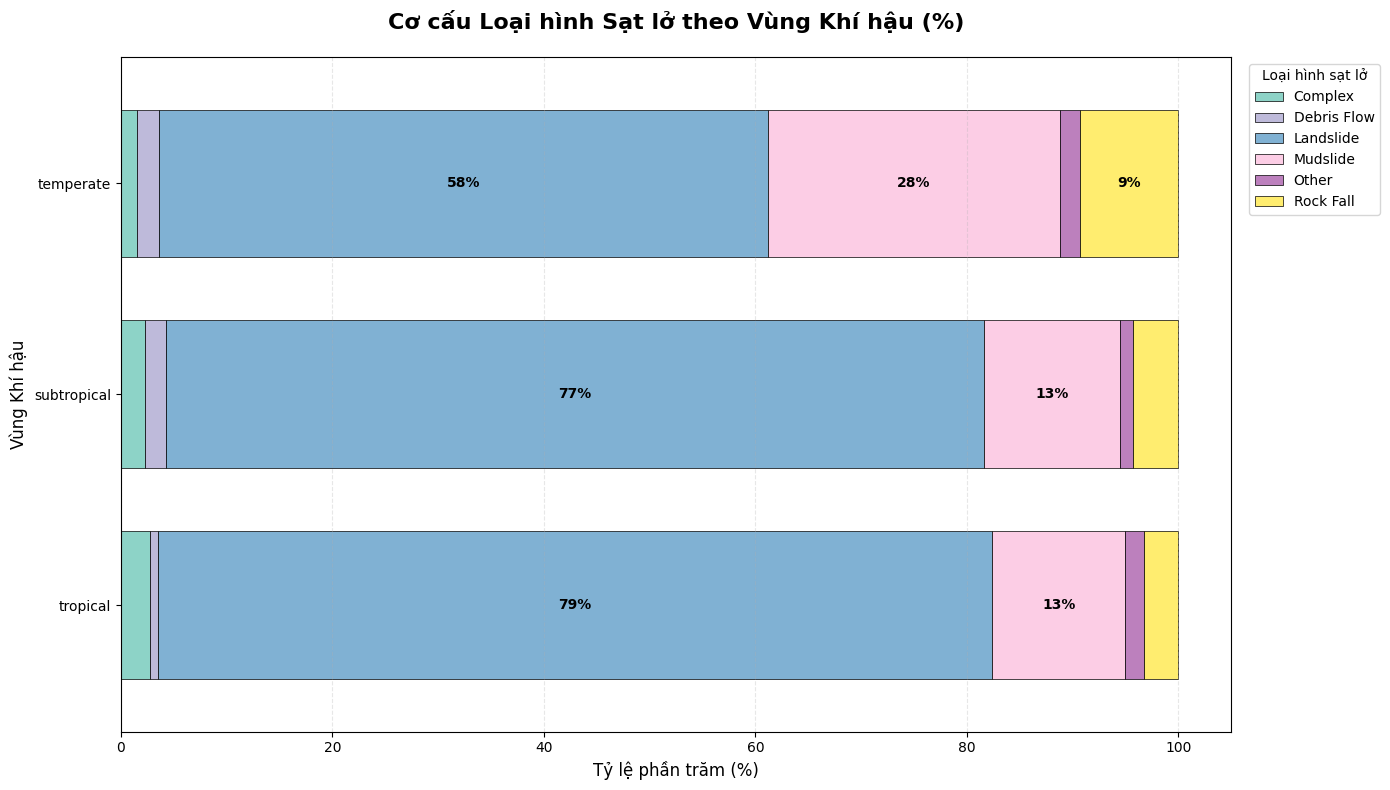

In [63]:
climate_order = ['tropical', 'subtropical', 'temperate']

# Lọc và làm sạch dữ liệu
df_cat = df.dropna(subset=['climate_zone', 'landslide_category']).copy()
df_cat = df_cat[df_cat['climate_zone'] != 'unknown']

# Chuẩn hóa tên loại hình
df_cat['category_clean'] = df_cat['landslide_category'].astype(str).str.replace('_', ' ').str.title()

# Lấy Top 5 loại hình phổ biến nhất, còn lại gom vào 'Other'
top_cats = df_cat['category_clean'].value_counts().head(5).index
df_cat['category_grouped'] = df_cat['category_clean'].apply(lambda x: x if x in top_cats else 'Other')

# Tạo bảng Pivot tính tỷ lệ phần trăm (normalize='index')
category_matrix = pd.crosstab(df_cat['climate_zone'], df_cat['category_grouped'], normalize='index') * 100

# Sắp xếp theo thứ tự khí hậu nóng -> lạnh
valid_climates = [c for c in climate_order if c in category_matrix.index]
category_matrix = category_matrix.loc[valid_climates]

# --- 2. VẼ BIỂU ĐỒ ---
plt.figure(figsize=(14, 8))

# Vẽ biểu đồ cột chồng 100%
ax = category_matrix.plot(
    kind='barh', 
    stacked=True, 
    figsize=(14, 8), 
    colormap='Set3', 
    edgecolor='black', 
    linewidth=0.5, 
    width=0.7
)

# --- 3. TRANG TRÍ ---
plt.title('Cơ cấu Loại hình Sạt lở theo Vùng Khí hậu (%)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tỷ lệ phần trăm (%)', fontsize=12)
plt.ylabel('Vùng Khí hậu', fontsize=12)

# Đặt chú thích (Legend) ra bên ngoài
plt.legend(title='Loại hình sạt lở', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10)

# Hiển thị số phần trăm (%) trực tiếp trên các khối màu
for c in ax.containers:
    # Chỉ hiển thị nhãn nếu giá trị lớn hơn 5% để tránh chồng chéo chữ
    labels = [f'{w:.0f}%' if w > 5 else '' for w in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=10, fontweight='bold')

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**Nhận xét**
- Landslide chiếm ưu thế tuyệt đối ở tất cả vùng
- Nhìn chung ở cả 3 loại vùng khí hậu đều có 2 loại chính là Landslide và Mudslide, nhưng giữa các vùng vẫn có sự khác biệt:
    + Vùng nhiệt đới và cận nhiệt đới: Gần như tương tự nhau (chiếm ưu thế bởi Landslide mà Mudslide)
    + Vùng ôn đới: Đa dạng hơn, có thêm cả RockFall nữa. Lanslide thấp nhất trong cả 3 vùng (58%) nhưng lại có Mudslide tăng cao (28%)

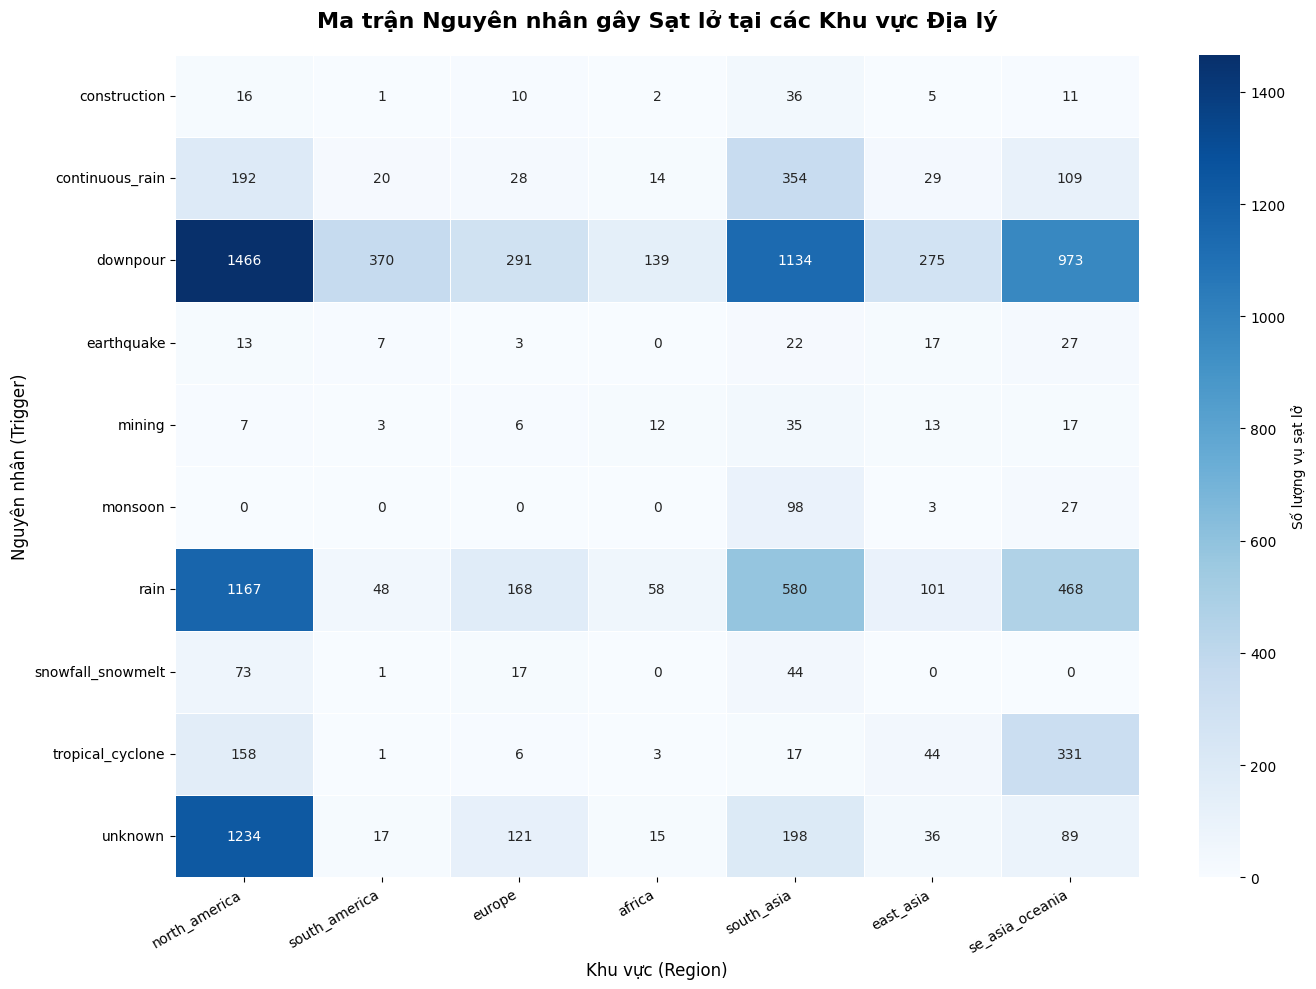

In [64]:
# Đảm bảo danh sách thứ tự vùng địa lý đã được định nghĩa
ordered_regions = ['north_america', 'south_america', 'europe', 'africa', 'south_asia', 'east_asia', 'se_asia_oceania']

# Lọc bỏ dòng thiếu dữ liệu trigger hoặc region
df_trig = df.dropna(subset=['region', 'landslide_trigger']).copy()

# Chuẩn hoá trigger (viết thường, bỏ khoảng trắng thừa)
df_trig['trigger_clean'] = df_trig['landslide_trigger'].astype(str).str.lower().str.strip()

# Chỉ lấy Top 10 nguyên nhân phổ biến nhất để biểu đồ rõ ràng
top_triggers = df_trig['trigger_clean'].value_counts().head(10).index
df_trig_top = df_trig[df_trig['trigger_clean'].isin(top_triggers)]

# Tạo bảng Pivot (Cross-tabulation)
# Đếm số vụ của từng nguyên nhân (Trigger) trong từng vùng (Region)
trigger_matrix = pd.crosstab(df_trig_top['trigger_clean'], df_trig_top['region'])

# Sắp xếp lại các cột theo thứ tự địa lý từ Tây sang Đông
valid_cols = [c for c in ordered_regions if c in trigger_matrix.columns]
trigger_matrix = trigger_matrix[valid_cols]

# 2. VẼ BIỂU ĐỒ HEATMAP 
plt.figure(figsize=(14, 10))

sns.heatmap(
    trigger_matrix, 
    annot=True,            
    fmt='d',               
    cmap='Blues',          
    linewidths=.5,       
    cbar_kws={'label': 'Số lượng vụ sạt lở'}
)

# --- 3. TRANG TRÍ ---
plt.title('Ma trận Nguyên nhân gây Sạt lở tại các Khu vực Địa lý', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Khu vực (Region)', fontsize=12)
plt.ylabel('Nguyên nhân (Trigger)', fontsize=12)

# Xoay nhãn trục X và Y cho dễ đọc
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

**Nhận xét**
Nguyên nhân đặc thù theo vùng khí hậu và địa lý
- Vùng nhiệt đới gió mùa, bão:
    + Mưa kéo dài (continuous_rain): đặc biệt nghiêm trọng ở Nam Á (354) do mùa mưa kéo dài.
    + Giông bão nhiệt đới (tropical_cyclone): ảnh hưởng nặng nhất ở Đông Nam Á & Úc (331) và Đông Á (44), phù hợp với vành đai bão Tây Thái Bình Dương và Ấn Độ Dương.
    + Giông mùa (monsoon): chỉ xuất hiện ở Nam Á, Đông Á, Đông Nam Á & Úc, đúng với các vùng có khí hậu gió mùa.
- Vùng ôn đới, núi cao:
    + Tuyết tan (snowfall_snowmelt): chỉ ảnh hưởng đến Bắc Mỹ, Châu Âu (Bắc Âu), Nam Á (vùng Himalaya).
- Vùng hoạt động kiến tạo mạnh:
    + Động đất (earthquake): ảnh hưởng nhiều nhất ở Đông Nam Á & Úc (27) và Nam Á (22), phù hợp với vành đai lửa Thái Bình Dương.

#### **3.2 Một số loại sạt lở có xu hướng gây chết người nhiều hơn các loại khác không?**


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4108\318931429.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




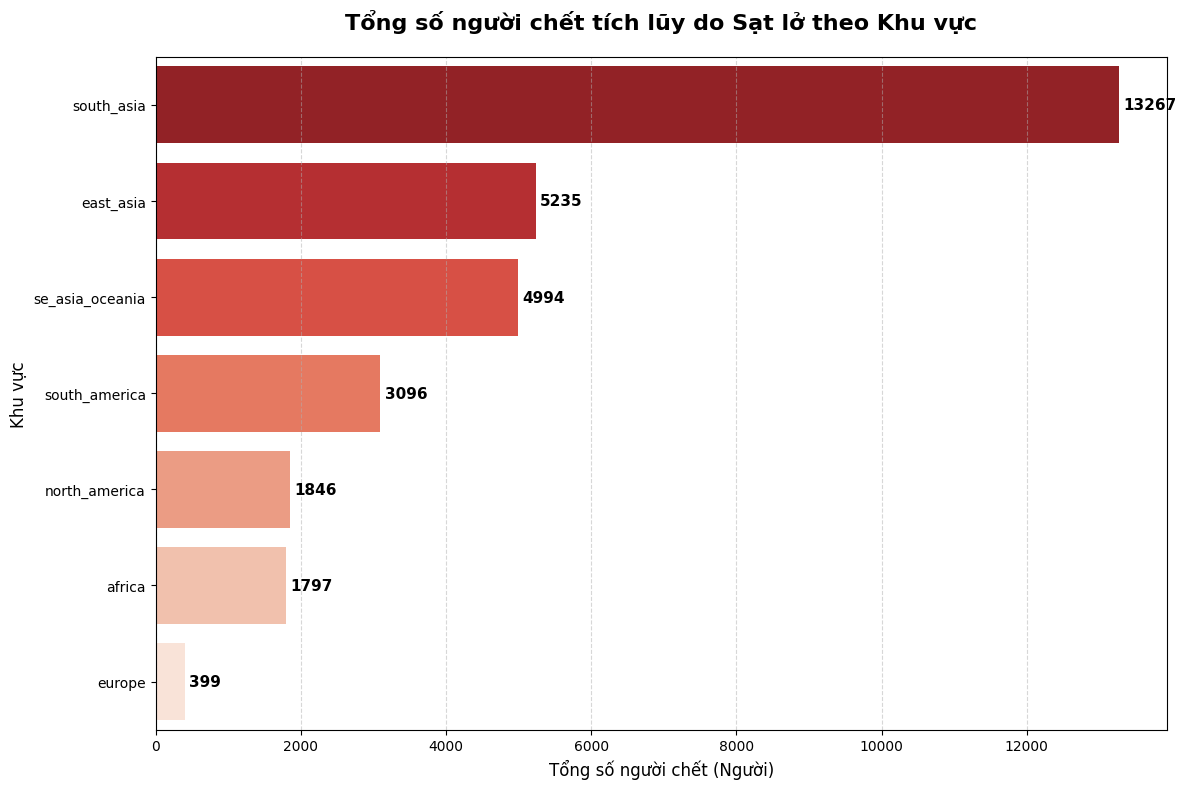

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. CHUẨN BỊ DỮ LIỆU
# Lọc các dòng có số người chết và vùng xác định
df_fatal = df.dropna(subset=['fatality_count', 'region']).copy()
df_fatal = df_fatal[df_fatal['region'] != 'unknown']

# Tính tổng số người chết để sắp xếp thứ tự các cột từ cao xuống thấp
region_fatal_sum = df_fatal.groupby('region')['fatality_count'].sum().sort_values(ascending=False).reset_index()
order_regions = region_fatal_sum['region'].tolist()

# 2. VẼ BIỂU ĐỒ
plt.figure(figsize=(12, 8))

# Vẽ biểu đồ cột ngang (Bar Chart)
ax = sns.barplot(
    data=region_fatal_sum,
    x='fatality_count',
    y='region',
    palette='Reds_r', # Tông màu đỏ thể hiện mức độ nghiêm trọng
    order=order_regions
)

# 3. TRANG TRÍ BIỂU ĐỒ
plt.title('Tổng số người chết tích lũy do Sạt lở theo Khu vực', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tổng số người chết (Người)', fontsize=12)
plt.ylabel('Khu vực', fontsize=12)

# Thêm nhãn số liệu (labels) trực tiếp vào cuối mỗi cột để dễ theo dõi
for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=11, fontweight='bold', color='black')

# Thêm lưới mờ cho trục X giúp dễ đối chiếu con số
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Nhận xét**
- Ở biểu đồ này ta có thể nhận ra rõ vùng Nam á đang là vùng có số người chết cao nhất (2007 - 2017), tiếp đó là Đông á và ĐNA&Úc.
- Điều đặc biệt là số người chết ở Bắc Mỹ (vùng được phân tích là có số lượng vụ sạt lở cao) lại thấp hơn rất nhiều ~8 lần so với top 1.
- Điều này ta có thể nói là tuy khí hậu quyết định số vụ sạt lở nhưng tử vong lại thuộc về các nguyên nhân khác (có thể là dân số, có thể là công tác cảnh báo,...)

<Figure size 1400x900 with 0 Axes>

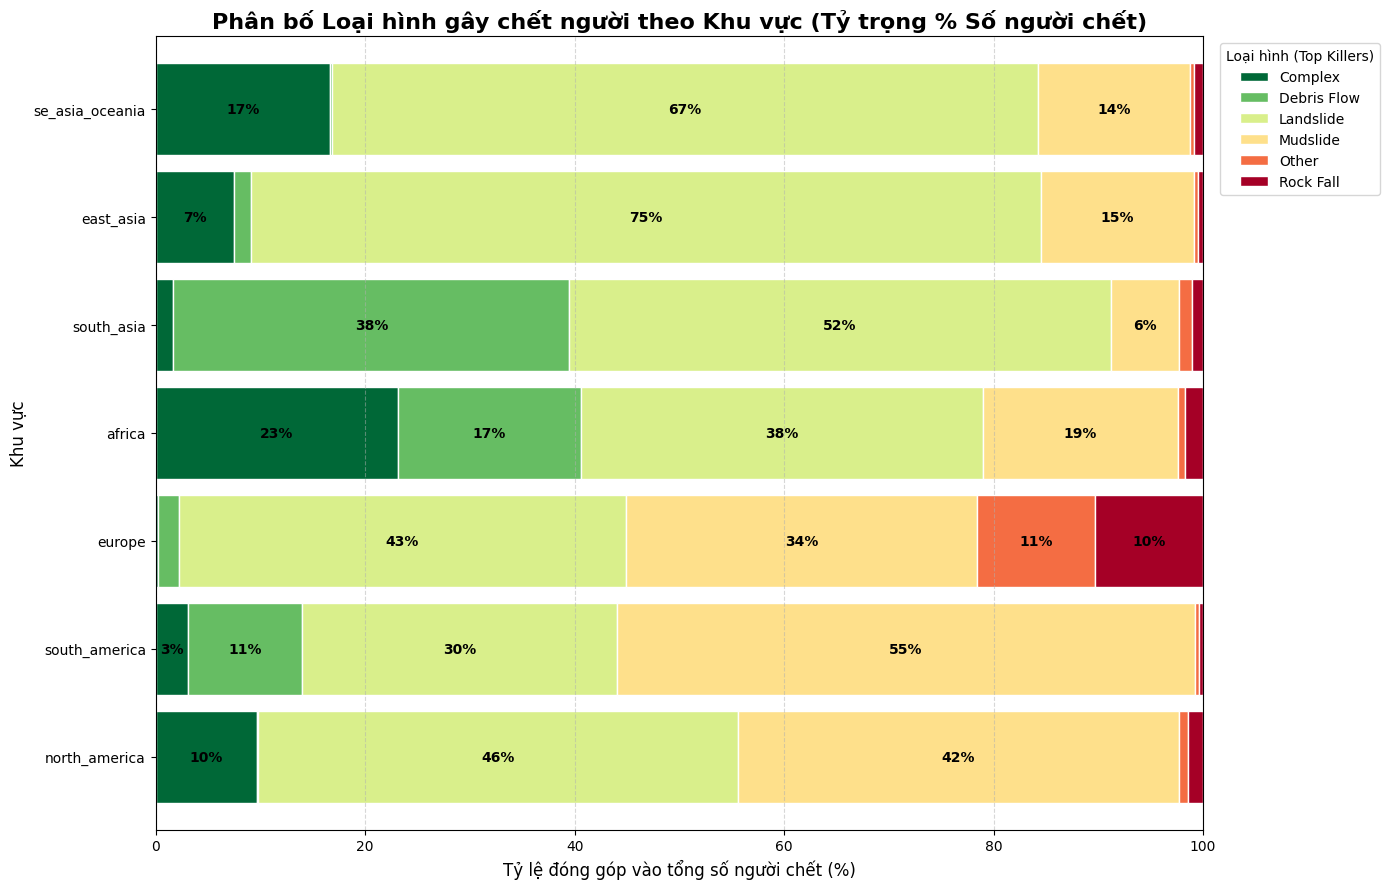

--- TỔNG SỐ NGƯỜI CHẾT THEO LOẠI HÌNH VÀ KHU VỰC ---


category_grouped  Complex  Debris Flow  Landslide  Mudslide  Other  Rock Fall
region                                                                       
north_america         179            1        846       777     17         26
south_america          97          337        930      1708     12         12
europe                  1            8        170       134     45         41
africa                416          313        690       336     11         31
south_asia            223         5019       6855       862    168        140
east_asia             390           86       3951       762     22         24
se_asia_oceania       833            6       3370       721     22         42

In [66]:

# Chỉ lấy các dòng có số người chết > 0 và có thông tin vùng/loại hình
df_fatal = df[
    (df['fatality_count'] > 0) & 
    (df['region'] != 'unknown')
].copy()

# Làm sạch tên loại hình
df_fatal['category_clean'] = df_fatal['landslide_category'].astype(str).str.replace('_', ' ').str.title()

# Gom nhóm các loại hình ít gặp vào 'Other' để biểu đồ gọn
# Tính tổng số người chết cho từng loại hình để tìm ra "Top Killers"
top_killers = df_fatal.groupby('category_clean')['fatality_count'].sum().sort_values(ascending=False).head(5).index
df_fatal['category_grouped'] = df_fatal['category_clean'].apply(lambda x: x if x in top_killers else 'Other')

# 2. TẠO BẢNG PIVOT (TỔNG SỐ NGƯỜI CHẾT)
# Lưu ý: aggfunc='sum' (tính tổng người chết) chứ không phải 'count' (đếm số vụ)
fatality_matrix = pd.crosstab(
    df_fatal['region'], 
    df_fatal['category_grouped'], 
    values=df_fatal['fatality_count'], 
    aggfunc='sum'
).fillna(0)

# Chuyển sang phần trăm (%)
fatality_pct = fatality_matrix.div(fatality_matrix.sum(axis=1), axis=0) * 100

# Sắp xếp thứ tự vùng (như cũ)
ordered_regions = [
    'north_america', 'south_america', 'europe', 'africa',
    'south_asia', 'east_asia', 'se_asia_oceania'
]
valid_regions = [r for r in ordered_regions if r in fatality_pct.index]
fatality_pct = fatality_pct.loc[valid_regions]

# 3. VẼ BIỂU ĐỒ
plt.figure(figsize=(14, 9))

# Dùng bảng màu 'Reds' hoặc 'Magma' để ám chỉ sự nguy hiểm/thương vong
ax = fatality_pct.plot(
    kind='barh', 
    stacked=True, 
    figsize=(14, 9), 
    colormap='RdYlGn_r', # Đỏ -> Xanh (Đỏ là nguy hiểm nhất) hoặc dùng 'tab10'
    edgecolor='white',
    width=0.85
)

# 4. TRANG TRÍ
plt.title('Phân bố Loại hình gây chết người theo Khu vực (Tỷ trọng % Số người chết)', fontsize=16, fontweight='bold')
plt.xlabel('Tỷ lệ đóng góp vào tổng số người chết (%)', fontsize=12)
plt.ylabel('Khu vực', fontsize=12)
plt.legend(title='Loại hình (Top Killers)', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Hiển thị số %
for c in ax.containers:
    # Chỉ hiện số nếu tỷ lệ > 3% để không bị rối
    labels = [f'{w:.0f}%' if w > 3 else '' for w in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

# 5. IN RA BẢNG TỔNG HỢP SỐ LIỆU THỰC TẾ
print("--- TỔNG SỐ NGƯỜI CHẾT THEO LOẠI HÌNH VÀ KHU VỰC ---")
display(fatality_matrix.loc[valid_regions].astype(int))

**Nhận xét**

- Landslide là sát thủ số 1 trên toàn thế giới, đặc biệt ở Châu Á.

- Debris Flow gây ra thảm họa quy mô lớn tập trung ở Nam Á.

- Mudslide là vấn đề nghiêm trọng đặc thù ở Nam Mỹ.

- Complex (sự kiện hỗn hợp) là mối đe dọa chính ở Đông Nam Á & Châu Đại Dương.

- Rock Fall là mối nguy hiểm đáng chú ý ở Châu Âu (tỷ lệ cao).

- Khu vực có tổng số tử vong thấp bất chấp có nhiều loại hình sạt lở và số vụ được ghi nhận nhiều (Như ở phần trước đã kết luận rằng có sự thiên kiến trong báo cáo nên số người chết vẫn chưa phản ánh đúng ở khu vực này)

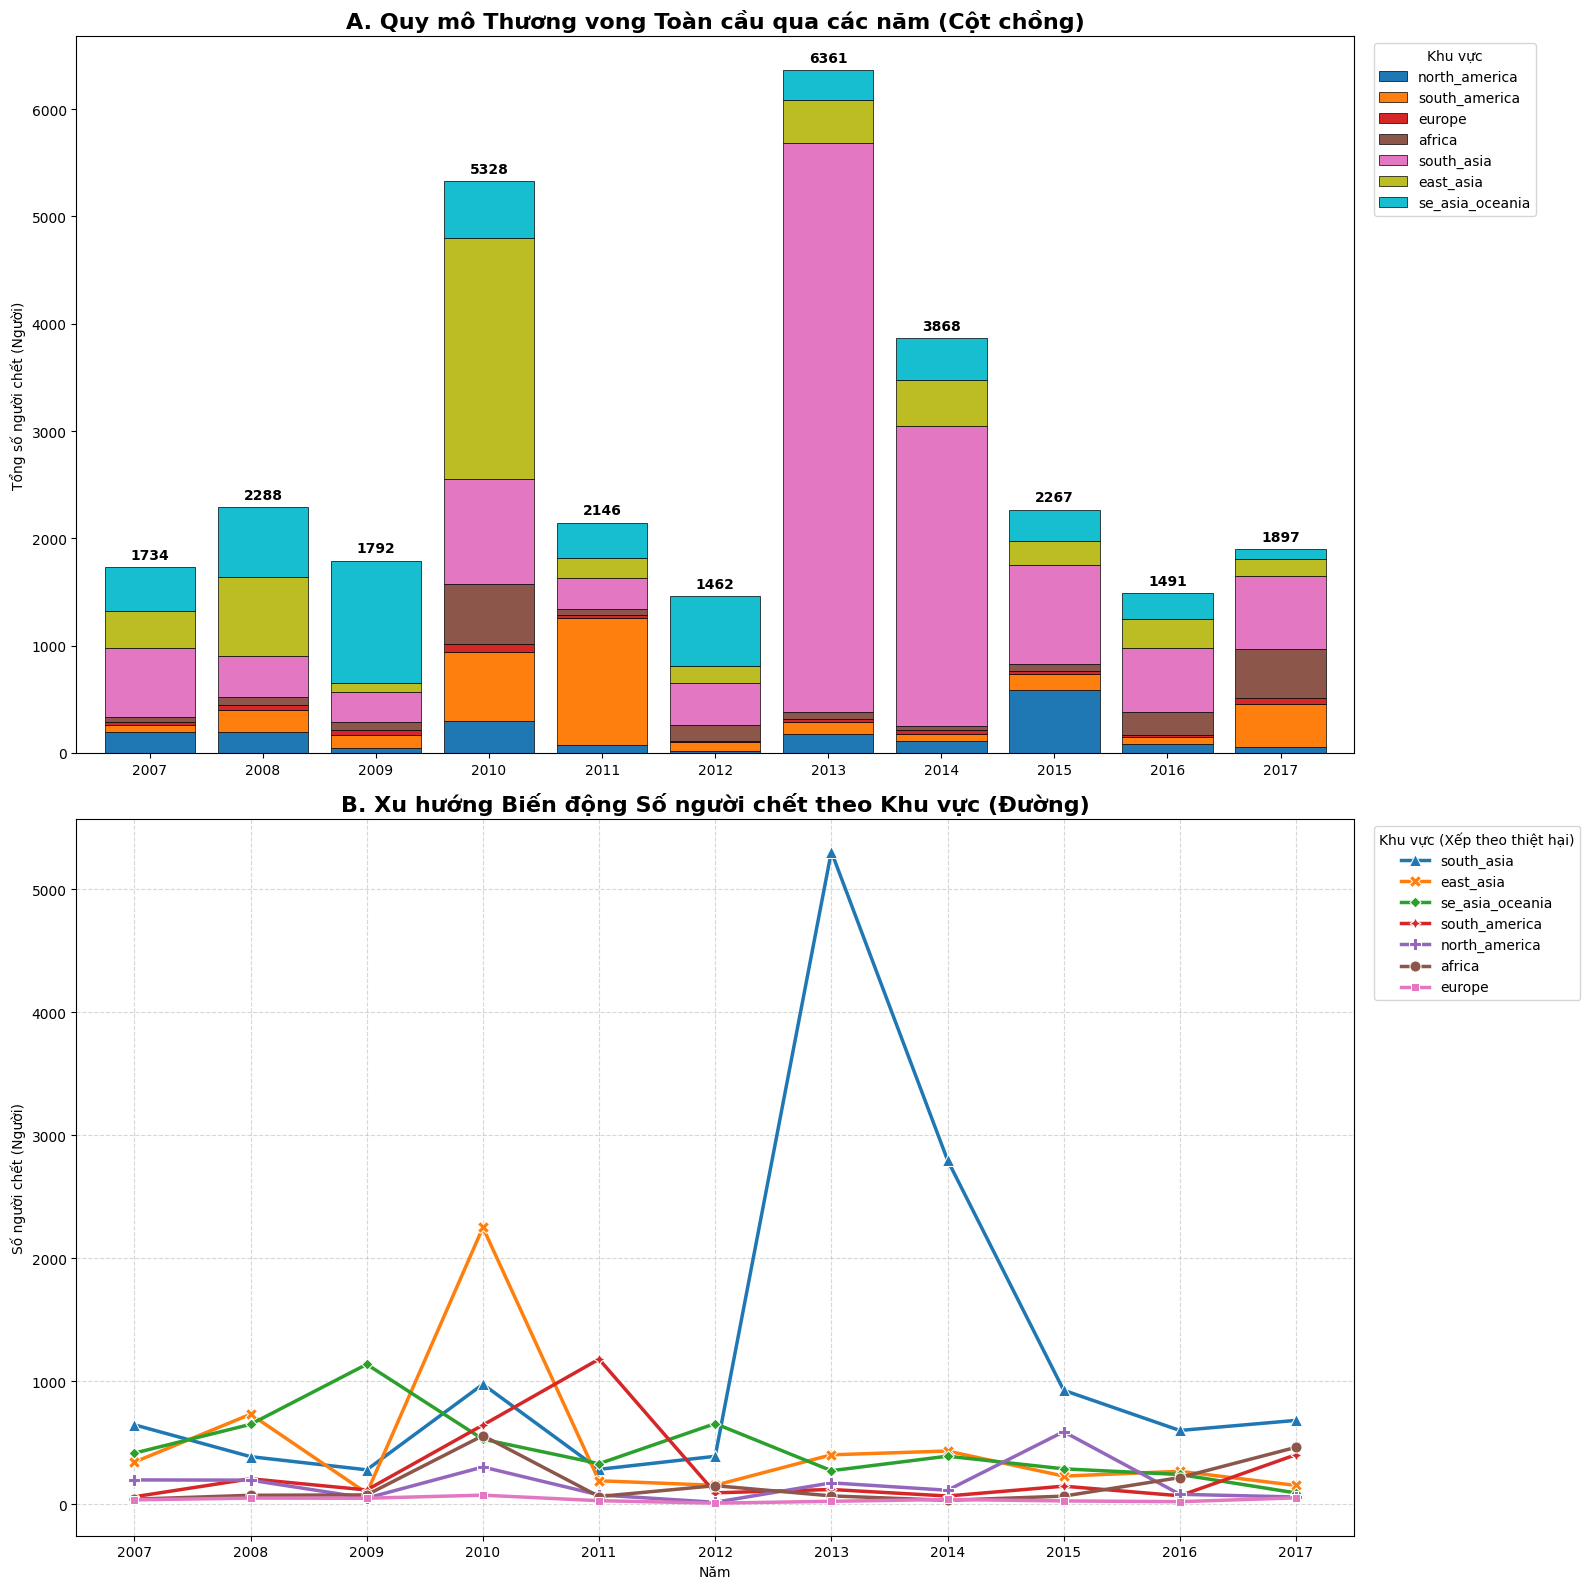

In [67]:
# Lọc dữ liệu sạch cho cả 2 biểu đồ  (bỏ unknown)
df_clean = df[
    (df['region'] != 'unknown')
].dropna(subset=['year', 'region', 'fatality_count']).copy()

# A. Dữ liệu cho Stacked Bar (Pivot Table)
pivot_fatal = df_clean.pivot_table(
    index='year', columns='region', values='fatality_count', 
    aggfunc='sum', fill_value=0
)
ordered_cols = ['north_america', 'south_america', 'europe', 'africa', 'south_asia', 'east_asia', 'se_asia_oceania']
valid_cols = [c for c in ordered_cols if c in pivot_fatal.columns]
pivot_fatal = pivot_fatal[valid_cols]

# B. Dữ liệu cho Line Plot
fatal_by_year = df_clean.groupby(['year', 'region'])['fatality_count'].sum().reset_index()
order_regions = fatal_by_year.groupby('region')['fatality_count'].sum().sort_values(ascending=False).index

# --- 2. VẼ BIỂU ĐỒ GỘP (2 Hàng, 1 Cột) ---
fig, axes = plt.subplots(2, 1, figsize=(16, 16))

# BIỂU ĐỒ 1: TỔNG QUY MÔ (STACKED BAR)
pivot_fatal.plot(
    kind='bar', stacked=True, colormap='tab10', 
    width=0.8, edgecolor='black', linewidth=0.5, ax=axes[0]
)
axes[0].set_title('A. Quy mô Thương vong Toàn cầu qua các năm (Cột chồng)', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Tổng số người chết (Người)')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Khu vực', bbox_to_anchor=(1.01, 1), loc='upper left')

# Thêm nhãn tổng trên đỉnh cột
totals = pivot_fatal.sum(axis=1)
for i, total in enumerate(totals):
    axes[0].text(i, total + 50, f'{int(total)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# BIỂU ĐỒ 2: XU HƯỚNG BIẾN ĐỘNG (LINE PLOT)
sns.lineplot(
    data=fatal_by_year, x='year', y='fatality_count', 
    hue='region', hue_order=order_regions, style='region',
    markers=True, dashes=False, linewidth=2.5, markersize=8, 
    palette='tab10', ax=axes[1]
)
axes[1].set_title('B. Xu hướng Biến động Số người chết theo Khu vực (Đường)', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Số người chết (Người)')
axes[1].set_xlabel('Năm')
axes[1].set_xticks(pivot_fatal.index)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend(title='Khu vực (Xếp theo thiệt hại)', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Nhận xét**
- nhìn chung ở giai đoạn 2009-2012: số người chết tăng cao, trùng khớp với giai đoạn hiện tượng thời tiết cực đoan gia tăng (El Niño/La Niña mạnh). Nghĩa là số vụ sạt lở càng cao thì số người chết có xu hướng cũng tăng theo. 
- Năm 2013, 2014 là năm có số người chết cao nhất của khu vực Nam á so với các khu vực khác (có thể là sự kiện hiểm hoạ lớn), đồng thời năm 2013 cũng là năm có số người chết cao nhất, tiếp đến là năm 2010.


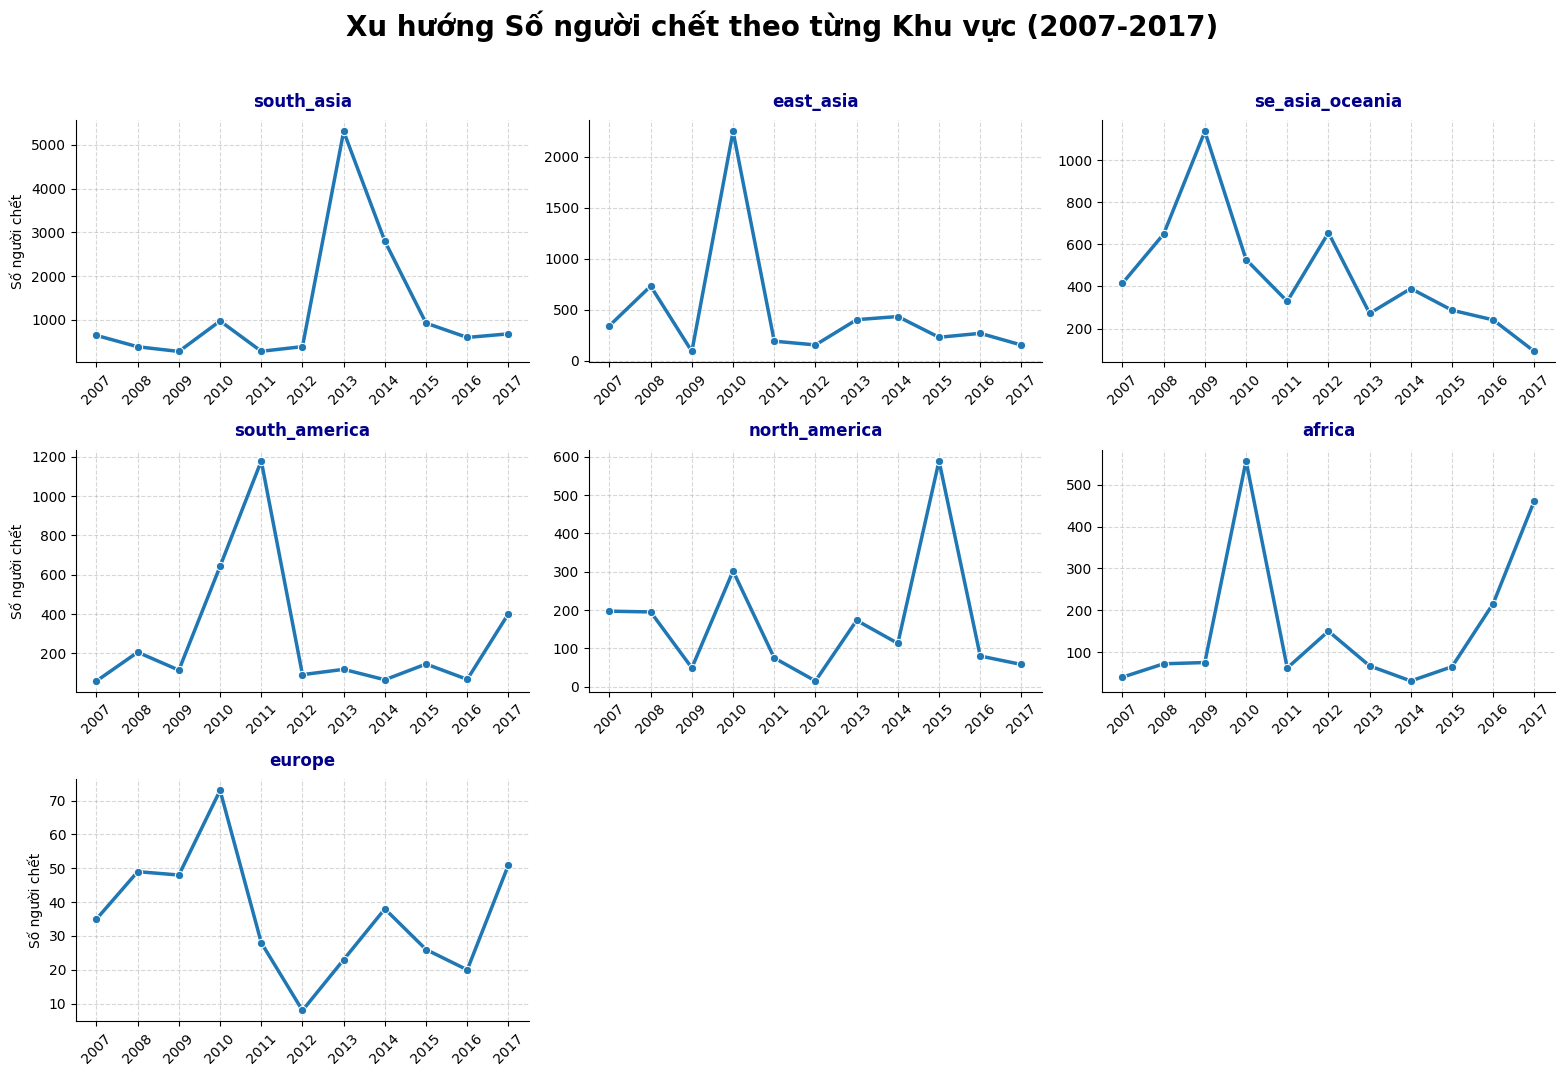

In [68]:


# Gom nhóm
yearly_fatal = df_trend.groupby(['year', 'region'])['fatality_count'].sum().reset_index()
order_regions = yearly_fatal.groupby('region')['fatality_count'].sum().sort_values(ascending=False).index

# 2. VẼ BIỂU ĐỒ SMALL MULTIPLES
g = sns.relplot(
    data=yearly_fatal,
    x='year', 
    y='fatality_count',
    col='region',          
    col_wrap=3,            
    col_order=order_regions, 
    kind='line',           
    marker='o',            
    height=3.5,            
    aspect=1.5,            
    linewidth=2.5,
    # sharex=False: Cho phép trục X độc lập (quan trọng để hiện số)
    # sharey=False: Cho phép trục Y độc lập (để soi vùng số liệu thấp)
    facet_kws={'sharey': False, 'sharex': False} 
)

# 3. TINH CHỈNH TRỤC X CHO TỪNG HÌNH (QUAN TRỌNG)
# Lặp qua từng biểu đồ nhỏ để cài đặt
for ax in g.axes.flatten():
    # Bắt buộc hiện nhãn trục dưới
    ax.tick_params(labelbottom=True)
    
    # Cài đặt các mốc năm cụ thể (Số nguyên từ 2007 đến 2017)
    years = range(2007, 2018)
    ax.set_xticks(years)
    
    # Xoay chữ 45 độ cho đỡ dính vào nhau
    ax.set_xticklabels(years, rotation=45, fontsize=10)
    
    # Thêm lưới mờ cho dễ nhìn
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Tô màu tiêu đề cho đẹp
    title = ax.get_title()
    # Xóa chữ 'region = ' mặc định của seaborn, chỉ giữ tên vùng
    clean_title = title.replace('region = ', '')
    ax.set_title(clean_title, fontsize=12, fontweight='bold', color='darkblue', pad=10)

# Tiêu đề tổng
g.fig.suptitle('Xu hướng Số người chết theo từng Khu vực (2007-2017)', fontsize=20, fontweight='bold', y=1.02)
g.set_axis_labels("", "Số người chết") # Bỏ nhãn trục X chung vì đã hiện ở từng hình

plt.tight_layout()
plt.show()

**Nhận xét**

- **Nam Á:** có số vụ tăng cao bất thường ở giai đoạn 2013 - 2014 (cao nhất hơn 5000), còn lại số người chết đều dưới <1000 người mỗi năm ho thấy đây là thảm họa cực đoan
  - Đỉnh cao >5000 người chết/năm trong 2013–2014 là cực kỳ bất thường, có thể liên quan đến:
    - Mưa lũ lịch sử (ví dụ: trận lũ Uttarakhand 2013 ở Ấn Độ, ~6000 người chết).
  - Động đất mạnh kết hợp sạt lở (ví dụ: Nepal 2015, nhưng có thể dữ liệu bạn có là 2014).

- **Đông Á:** Có đỉnh số người chết tại năm 2010 (hơn 2000), còn lại đeèu có số vụ < 5000 (Lũ lụt và sạt lở ở Trung Quốc năm 2010 (hơn 2000 người chết do thiên tai liên quan đến mưa)
- **ĐNÁ&Úc:** năm số người chết cao nhất là 2009 sau đó giảm, và số người chết tăng trở lại vào năm 2012, và sau đó giảm dần tới 2017 (Phù hợp với chu kỳ hoạt động của bão nhiệt đới và hiện tượng El Niño/La Niña ảnh hưởng đến mưa lớn ở Đông Nam Á và Úc.)
- **Nam Mỹ:** Tăng cao từ năm 2010-2011, cao nhất 2011, ngoài ra các năm có số người chết <200, 2016-2017 có xu hướng tăng.
    - Mưa lớn kỷ lục ở Brazil (2011) gây lở đất ở Rio de Janeiro, hàng trăm người chết.
    - Hiện tượng La Niña 2010–2011 gây mưa lớn bất thường ở Nam Mỹ
- **Bắc Mỹ:** bắt đầu tăng từ 2010 (300), sau đó giảm tới 2012, tăng tơi năm 2015 (cao nhất 600), và sau đó giảm một cách nhanh chóng 
  - Mưa lũ lịch sử và lở đất ở Washington (2014), California (2015).
- **Châu Phi:** 2010 là cao nhất (hơn 500 ng chết) , từ năm 2015 - 2017 có xu hướng tăng nhanh
- **Châu Âu:** 2009-2010 tăng  (đỉnh là 70 người chết), giảm mạnh 2012 (<10) và có xu hướng tăng lên (2014 là gần 40 ng), 2016-2017 có xu hướng tăng


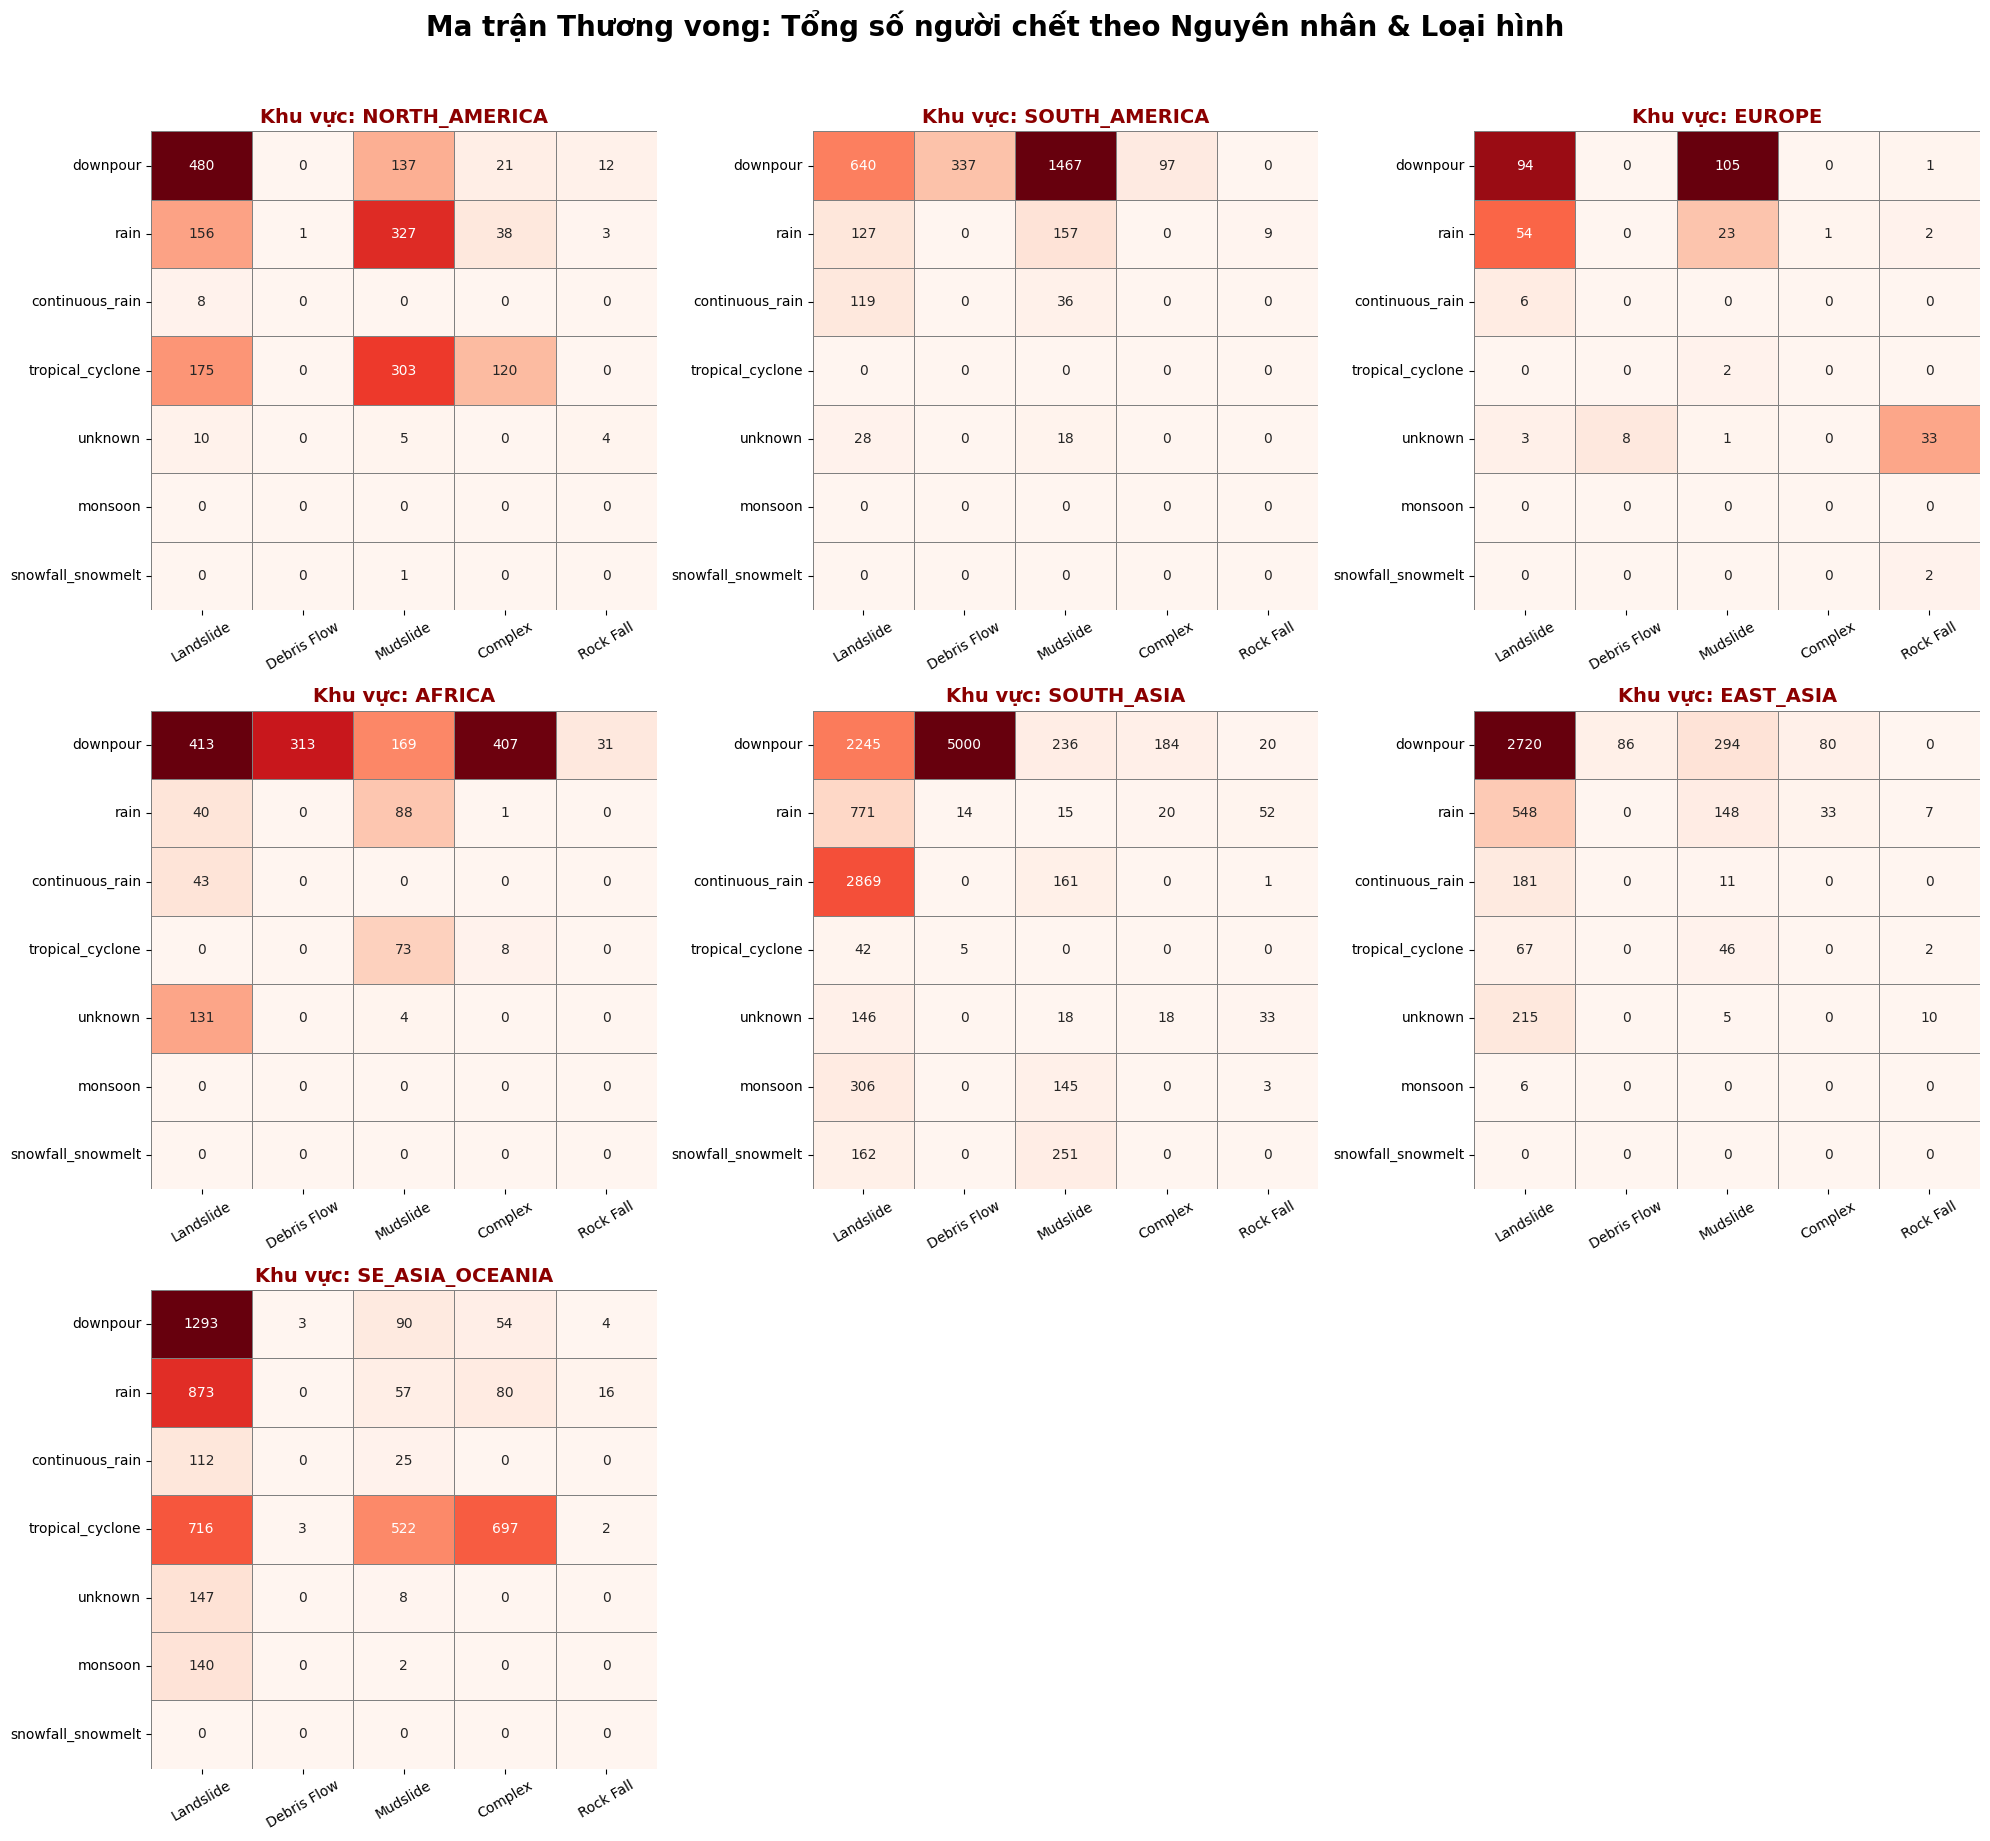

In [69]:
df_fatal_heat = df.dropna(subset=['region', 'landslide_trigger', 'landslide_category', 'fatality_count']).copy()
df_fatal_heat = df_fatal_heat[df_fatal_heat['fatality_count'] > 0] # Chỉ quan tâm các vụ có người chết

# Làm sạch dữ liệu văn bản
df_fatal_heat['trigger_clean'] = df_fatal_heat['landslide_trigger'].astype(str).str.lower().str.strip()
df_fatal_heat['category_clean'] = df_fatal_heat['landslide_category'].astype(str).str.replace('_', ' ').str.title()

# Lọc Top các Nguyên nhân và Loại hình phổ biến nhất (để biểu đồ không bị loãng)
top_triggers = df_fatal_heat.groupby('trigger_clean')['fatality_count'].sum().sort_values(ascending=False).head(7).index
top_categories = df_fatal_heat.groupby('category_clean')['fatality_count'].sum().sort_values(ascending=False).head(5).index

# Chỉ giữ lại dữ liệu thuộc Top này
df_filtered = df_fatal_heat[
    (df_fatal_heat['trigger_clean'].isin(top_triggers)) & 
    (df_fatal_heat['category_clean'].isin(top_categories))
]

# Danh sách vùng cần vẽ
ordered_regions = ['north_america', 'south_america', 'europe', 'africa', 'south_asia', 'east_asia', 'se_asia_oceania']
valid_regions = [r for r in ordered_regions if r in df_filtered['region'].unique()]

# --- 2. THIẾT LẬP LƯỚI BIỂU ĐỒ ---
n_cols = 3
n_rows = math.ceil(len(valid_regions) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
axes = axes.flatten()

# --- 3. VẼ TỪNG HEATMAP CHO TỪNG VÙNG ---
for i, region in enumerate(valid_regions):
    ax = axes[i]
    
    # Lấy dữ liệu vùng
    data_region = df_filtered[df_filtered['region'] == region]
    
    # TẠO PIVOT TABLE (QUAN TRỌNG: TÍNH TỔNG SỐ NGƯỜI CHẾT)
    # values='fatality_count', aggfunc='sum'
    matrix = pd.pivot_table(
        data_region, 
        values='fatality_count', 
        index='trigger_clean', 
        columns='category_clean', 
        aggfunc='sum',
        fill_value=0
    )
    
    # Reindex để đồng bộ trục X, Y cho mọi biểu đồ
    matrix = matrix.reindex(index=top_triggers, columns=top_categories, fill_value=0)
    
    # Vẽ Heatmap
    # Dùng màu 'Reds' để thể hiện sự nguy hiểm (Máu/Thương vong)
    sns.heatmap(
        matrix, 
        annot=True, 
        fmt='.0f', # Hiển thị số nguyên (không có số lẻ)
        cmap='Reds', 
        cbar=False, 
        linewidths=.5,
        linecolor='gray',
        ax=ax
    )
    
    # Trang trí
    ax.set_title(f'Khu vực: {region.upper()}', fontsize=14, fontweight='bold', color='darkred')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=30)

# Xóa ô thừa
for j in range(len(valid_regions), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Ma trận Thương vong: Tổng số người chết theo Nguyên nhân & Loại hình', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Bảng nhận xét**

| Khu vực | Đặc trưng Rủi ro & Tác nhân Chính | Loại hình Nguy hiểm & Hệ quả | Kiến nghị Quản lý Rủi ro |
| :--- | :--- | :--- | :--- |
| **Đông Nam Á & Úc** | **Thiên tai kép:** Bão nhiệt đới kết hợp mưa lũ là mối đe dọa chính. | Kích hoạt sạt lở **Phức hợp (Complex)** và quy mô lớn, gây thiệt hại nặng về người. | Tối ưu hóa cảnh báo sớm bão; chú trọng nguy cơ dòng bùn đá (**Debris Flow**) sau bão. |
| **Nam Á** | **Địa hình Himalaya:** Nhạy cảm với mưa dài ngày, mưa lớn tập trung và tuyết tan. | **Dòng bùn đá (Debris Flow)** là vấn đề then chốt (5000 vụ) gây tử vong hàng loạt. | Thiết lập hệ thống cảnh báo mưa cực đoan và bản đồ vùng nguy cơ dòng bùn đá. |
| **Đông Á** | **Mối đe dọa đơn giản nhưng khổng lồ:** Chủ yếu do mưa lớn đột ngột. | Tạo ra khối lượng sự cố **Sạt lở đất (Landslide)** cực lớn (2720 vụ). | Tập trung dự báo ngưỡng mưa và gia cố, ổn định sườn dốc trên diện rộng. |
| **Châu Phi** | **Nền địa chất kém ổn định:** Cấu trúc dễ bị phá hủy hoàn toàn dưới áp lực nước lớn. | Kịch bản tử thần: **Mưa xối xả (Downpour)** dẫn đến sạt lở **Phức hợp** và **Dòng vụn đá**. | Ưu tiên mạng lưới trạm đo mưa tự động; quy hoạch lại dân cư xa đường đi của dòng vụn đá. |
| **Bắc Mỹ** | **Rủi ro từ Bão & Mưa lớn:** Sự kết hợp giữa bão nhiệt đới và độ ẩm đất cao. | **Lũ bùn (Mudslide)** là loại hình nguy hiểm nhất, xảy ra đa dạng dưới nhiều điều kiện thời tiết. | Tăng cường giám sát độ ẩm đất; cảnh báo lũ quét/lũ bùn tại các vùng nhạy cảm với bão. |
| **Nam Mỹ** | **Mức độ thảm khốc cực cao:** 90% ca tử vong gắn liền với các hiện tượng mưa cực đoan. | **"Mưa xối xả - Lũ bùn"** là sát thủ số 1; dòng vụn đá chiếm tỷ trọng lớn do địa hình dốc cao. | Xây dựng bản đồ rủi ro lũ bùn đá; sơ tán dân dựa trên ngưỡng mưa (rainfall threshold). |
| **Châu Âu** | **Hạ tầng an toàn cao:** Thương vong thấp nhờ quản lý tốt nhưng vẫn chịu rủi ro từ núi cao. | Đặc thù **Đá rơi (Rock Fall)** do biến đổi nhiệt độ và **Tuyết tan (Snowmelt)** mùa xuân. | Duy trì rào chắn đá rơi; theo dõi sát nhiệt độ vùng núi cao để cảnh báo trượt lở đá. |

**Insight chung:** Trong khi các nước phát triển (Bắc Mỹ, Châu Âu) tập trung vào giám sát hạ tầng và đá rơi, thì các vùng nhiệt đới (Á, Phi, Nam Mỹ) đang đối mặt với thảm họa nhân mạng khổng lồ từ **Lũ bùn và Dòng vụn đá** do mưa cực đoan. Quản lý rủi ro toàn cầu cần chuyển dịch từ theo dõi "số vụ" sang dự báo "ngưỡng nguy hiểm" theo đặc thù từng vùng.

#### **3.3 Tổng kết**

**Kết luận:** Mối quan hệ nhân - quả trong thảm họa sạt lở không chỉ dừng lại ở việc "mưa gây sạt lở", mà là sự tương tác phức tạp giữa Cường độ tác nhân (Trigger), Loại hình cơ lý (Category) và Năng lực ứng phó của khu vực.

**1. Mối quan hệ Nhân - Quả và các "Sát thủ" hàng đầu**

- Nguyên nhân gốc rễ: Downpour (Mưa lớn xối xả) là tác nhân hàng đầu kích hoạt các vụ việc có độ khốc liệt cao trên toàn cầu. Ngoài ra, các yếu tố đặc thù như Tropical Cyclone (Bão), Monsoon (Gió mùa) và Snowmelt (Tuyết tan) đóng vai trò là ngòi nổ riêng biệt cho từng vùng khí hậu.
- Loại hình gây hậu quả nghiêm trọng nhất: * Landslide (Sạt lở đất): Chiếm ưu thế tuyệt đối về số lượng và là nguyên nhân gây tử vong số 1 tại Châu Á.
  - Debris Flow (Dòng bùn đá): Là "vấn đề then chốt" gây thảm họa hàng loạt tại Nam Á.
  - Mudslide (Lũ bùn): Là sát thủ đặc thù tại Nam Mỹ và Bắc Mỹ, nơi đất dễ bão hòa nước nhanh chóng.
  - Complex (Sạt lở hỗn hợp): Mối đe dọa chính tại Đông Nam Á, nơi thiên tai bão lũ thường đi kèm nhiều hiện tượng đồng thời.
  
**2. Sự phân bố hậu quả theo Khu vực địa lý**

Số liệu thương vong phản ánh một thực tế đối lập giữa các khu vực địa lý:
- Tâm điểm tử vong (Nam Á, Đông Á, ĐNA): Đây là nơi cần quan tâm đặc biệt. Nam Á đứng đầu về số người chết, đặc biệt cao điểm vào năm 2013-2014 do các sự kiện thảm khốc liên quan đến địa hình Himalaya và gió mùa.
- Nghịch lý Bắc Mỹ & Châu Âu: Tuy Bắc Mỹ có số vụ ghi nhận cao ngất ngưỡng (do thiên kiến báo cáo), nhưng tỷ lệ tử vong lại thấp hơn Nam Á gần 8 lần. Điều này cho thấy công tác cảnh báo và hạ tầng tại đây giúp giảm thiểu đáng kể thiệt hại nhân mạng.
- Đặc thù địa phương: Châu Âu ghi nhận tỷ lệ tử vong do Rock Fall (Đá rơi) đáng chú ý hơn các vùng khác do đặc điểm vùng núi cao và tuyết tan.
  
**3. Tác động của Khí hậu toàn cầu (ENSO)**

- Giai đoạn 2009-2012 chứng kiến số người chết tăng cao kỷ lục, trùng khớp với các chu kỳ El Niño/La Niña mạnh. Khi các hiện tượng thời tiết cực đoan gia tăng, quy luật "số vụ tăng - số người chết tăng" thể hiện rất rõ nét.
  
**4. Insight Tổng kết**

Để trả lời câu hỏi "cần làm gì để đề phòng", chúng ta không thể áp dụng một công thức chung mà phải tập trung vào các Kịch bản rủi ro trọng điểm:

> **a. Châu Á & Nam Mỹ (Vùng nguy cơ cao):** Ưu tiên xây dựng hệ thống cảnh báo sớm cho Mudslide và Debris Flow dựa trên ngưỡng mưa cực đoan (Downpour). Đây là những loại hình có tốc độ di chuyển cực nhanh, cần sơ tán dân cư ngay lập tức thay vì chỉ theo dõi.

> **b. Đông Nam Á (Vùng thiên tai kép):** Cần tích hợp dự báo sạt lở vào trong dự báo bão nhiệt đới. Các vụ sạt lở Phức hợp thường xảy ra sau bão, đòi hỏi công tác cứu hộ và giám sát phải kéo dài ngay cả khi bão đã tan.

> **c. Châu Âu & Bắc Mỹ (Vùng hạ tầng cao):** Tập trung vào giám sát các tuyến đường giao thông vùng núi để phòng tránh Đá rơi và Lũ bùn quy mô nhỏ nhưng thường xuyên, ảnh hưởng đến an toàn giao thông.

**Kết luận:** Hậu quả nghiêm trọng nhất về mặt con người nằm ở sự kết hợp giữa Mưa cường độ cao và các loại hình sạt lở chảy lỏng (Mudslide/Debris Flow) tại các khu vực đang phát triển. Việc quản lý rủi ro cần chuyển dịch từ "thống kê số vụ" sang "phân tích kịch bản tử thần" theo từng vùng đặc thù. 
